In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
random_seed = 108
test_size = 0.2

In [3]:

score_df = pd.DataFrame.from_dict(
    {'model': [],
             'accuracy':[],
             'outcome':[]})

In [4]:
df = pd.read_excel(io='AUSCOVID_DATA_2023-04-02_1133.xlsx')

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

### Composite variables
1. 'pre-existing cardiovascular disease' - a feature variable of either as history of: 
    - coronary artery disease, 
    - heart failure or cardiomyopathy, 
    - atrial fibrillation or flutter, 
    - severe valvular disease, 
    - peripheral arterial disease and 
    - stroke or transient ischaemic attack (TIA)
2. 'cardio_complication' - an outcome variable that has the presence of either: 
    - new onset atrial fibrillation or flutter, 
    - high-grade atrioventricular block, 
    - sustained ventricular tachycardia, 
    - new heart failure or cardiomyopathy, 
    - pericarditis,
    - myocarditis or myopericarditis, 
    - pulmonary embolism and 
    - cardiac arrest

### Exclusion variables
1. egfr as it is a derivative of creatinine
2. nursing home as correlated with age
3. 'hs_troponin_i','hs_troponin_t' as they are largely missing
4. 'platelets' as they are missing

In [6]:
# excluded efgr as derivative of creatinine
# 
cols = ['age','sex','healthcare_worker','hypertension',
        'hypercholesterolemia',
       'diabetes' ,'smoker','copd','asthma','ckd','dialysis','height','weight','sbp','dbp',
        'heart_rate','respiratory_rate','temperature','spo2','fio2','po2','pco2','lactate_arterial','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','procalcitonin','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous','chest_xray','vaccinated','pacemaker','troponin_uln','coronary_med_history_col']

# get rid of past medical_history
# 'fio2','po2','pco2'

coronary_med_history_col = [
    'coronary_artery_disease',
    'heart_failure_cardiomyopathy',
    'af_flutter',
    'severe_valvular_disease',
    'stroke_tia',
    'pad']

cardio_complication = [
    'pericarditis',
    'new_2nd_degree_heart_block',
    'new_3rd_degree_heart_block',
    'conscious_sustained_vt',
    'new_cardiomyopathy_hf',
    'new_af_flutter',
    'myocarditis_myopericarditis',
    'pulm_embolus',
    'cardiac_arrest'
]

# replace No's to 0
for col in coronary_med_history_col + cardio_complication + ['past_medical_history']:
    df[col] = df[col].replace(2, 0)


df['death'] = [1 if x == 1 or x == 2 else 0 for x in df['discharge_status']]
df['vaccinated'] = [1 if x == 2 or x == 3 or  x == 4 else 0 for x in df['vaccination_status']]
df['pacemaker'] = [1 if x == 1 else 0 for x in df['ppm_icd']]
df['coronary_med_history_col'] = df[coronary_med_history_col].any(axis=1)


categorical_col = ['sex','healthcare_worker','hypertension',
        'hypercholesterolemia','diabetes', 'smoker','copd','asthma','ckd','dialysis',
                   'chest_xray','vaccinated','pacemaker','troponin_uln','coronary_med_history_col']



predictor = ['intubation_dummy','death','cardio_complication']

df['intubation_dummy'] =  [1 if x == 1 else 0 for x in df['intubation']]
df['cardio_complication'] = df[cardio_complication].any(axis=1)


data_predictor = df[predictor]
data = df[cols+predictor]

In [7]:
float_col = ['height','sbp','dbp','heart_rate','weight','temperature','fio2','po2',
             'pco2','spo2','crp','lactate_arterial',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','procalcitonin','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous']
int_col = ['age']

In [8]:
data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_26672\935426440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)


In [9]:
df_dummy  = pd.get_dummies(data,columns = categorical_col, dummy_na=False,drop_first=True)
df_dummy.head()

# drop dummy variables that contain all 0
#df_dummy = df_dummy.drop(['healthcare_worker_nan','sex_nan',
#                          'chest_xray_nan','pacemaker_nan','vaccinated_nan',
#                         'hypertension_nan',
#        'hypercholesterolemia_nan','diabetes_nan', 'smoker_nan','copd_nan','asthma_nan','ckd_nan','dialysis_nan',
#                          'coronary_med_history_col_nan','past_medical_history_nan'],axis=1)

,age,height,weight,sbp,dbp,heart_rate,respiratory_rate,temperature,spo2,fio2,...,asthma_2.0,ckd_2.0,dialysis_2.0,dialysis_3.0,chest_xray_2,chest_xray_3,vaccinated_1,pacemaker_1,troponin_uln_2.0,coronary_med_history_col_True
0,56,NaN,NaN,174.0,116.0,104.0,23.0,36.2,96.0,NaN,...,True,True,False,True,False,True,False,True,False,False
1,33,NaN,NaN,116.0,66.0,102.0,26.0,37.9,91.0,NaN,...,True,True,False,True,True,False,False,True,True,False
2,32,NaN,NaN,113.0,69.0,100.0,22.0,37.6,96.0,NaN,...,True,True,False,True,True,False,False,True,False,False
3,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,...,True,True,False,True,True,False,False,True,False,True
4,54,NaN,NaN,159.0,94.0,108.0,48.0,NaN,84.0,50.0,...,True,True,False,True,True,False,False,True,True,False


# Model Building

In [10]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(np.arange(df_dummy.shape[0]), test_size=test_size, random_state=random_seed)

## Baseline model
No feature selection

In [13]:
#score_df = pd.read_csv("result/outcome.csv",index_col=0)

In [14]:
for p in predictor:
    y = df_dummy[p]
    X = df_dummy.drop(predictor, axis=1)
    X_train= X.iloc[train,:]
    y_train = y.iloc[train]
    
    test_pipe = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy='median'),
        StandardScaler(), 
        LogisticRegression(penalty = None,max_iter = 10000))
    tmp_df = pd.DataFrame.from_dict({'model': ['baseline_median_impute'],
               'outcome': [p],
               'accuracy': [np.mean(cross_val_score(test_pipe, X_train, y_train, cv=5))]})
    score_df = pd.concat([score_df,tmp_df],ignore_index=True)

In [15]:
score_df.to_csv("result/outcome.csv")

## Logistic regression with feature selection

In [17]:
score_df = pd.read_csv("result/outcome.csv",index_col=0)

In [18]:
for p in predictor:
    y = df_dummy[p]
    X = df_dummy.drop(predictor, axis=1)
    X_train= X.iloc[train,:]
    y_train = y.iloc[train]
    
    pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = None),n_features_to_select='auto')),
        ("logistic",LogisticRegression(random_state=random_seed,max_iter = 1000,penalty = None))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/logistic_feature_selection_median_impute"+p+".pickle")

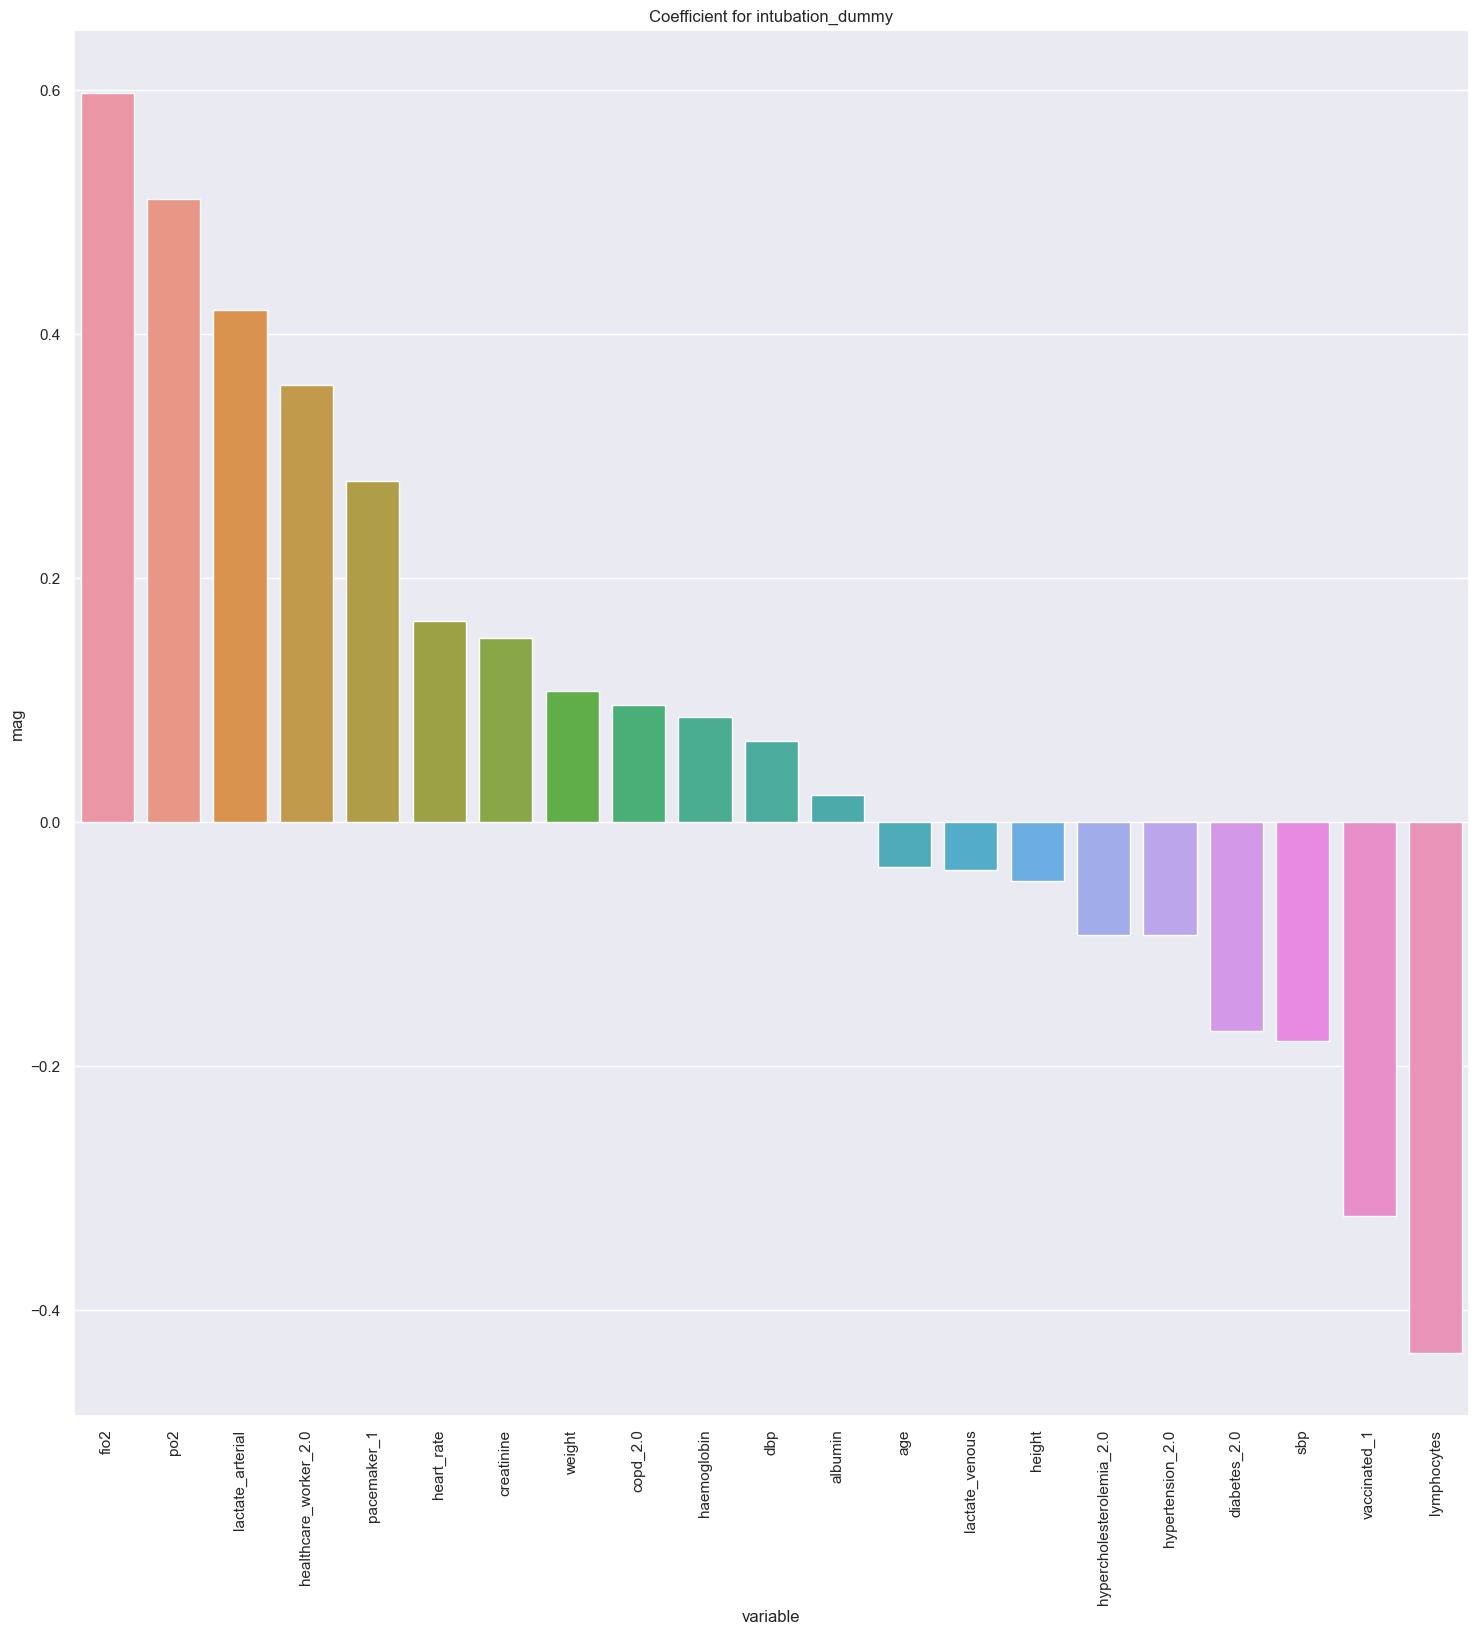

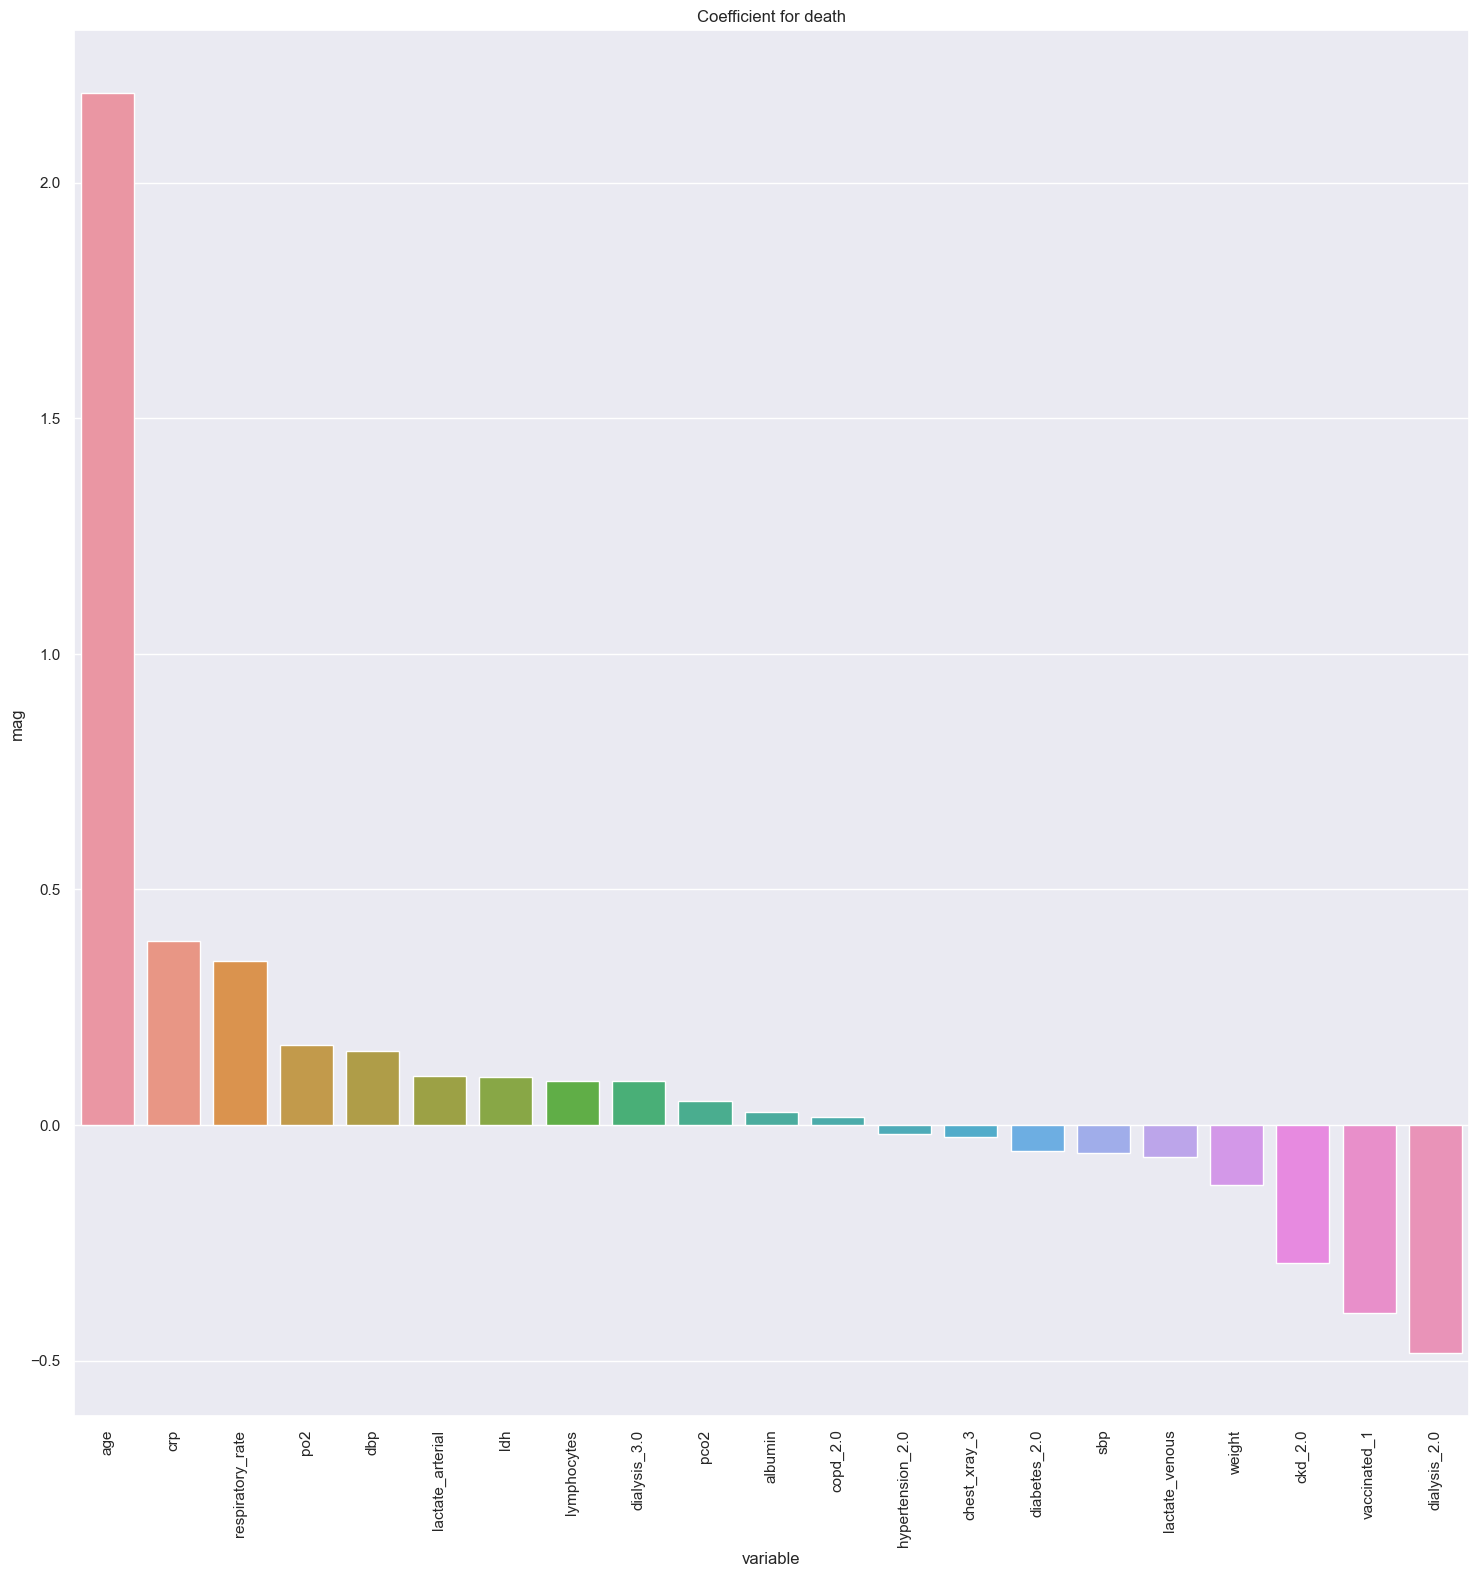

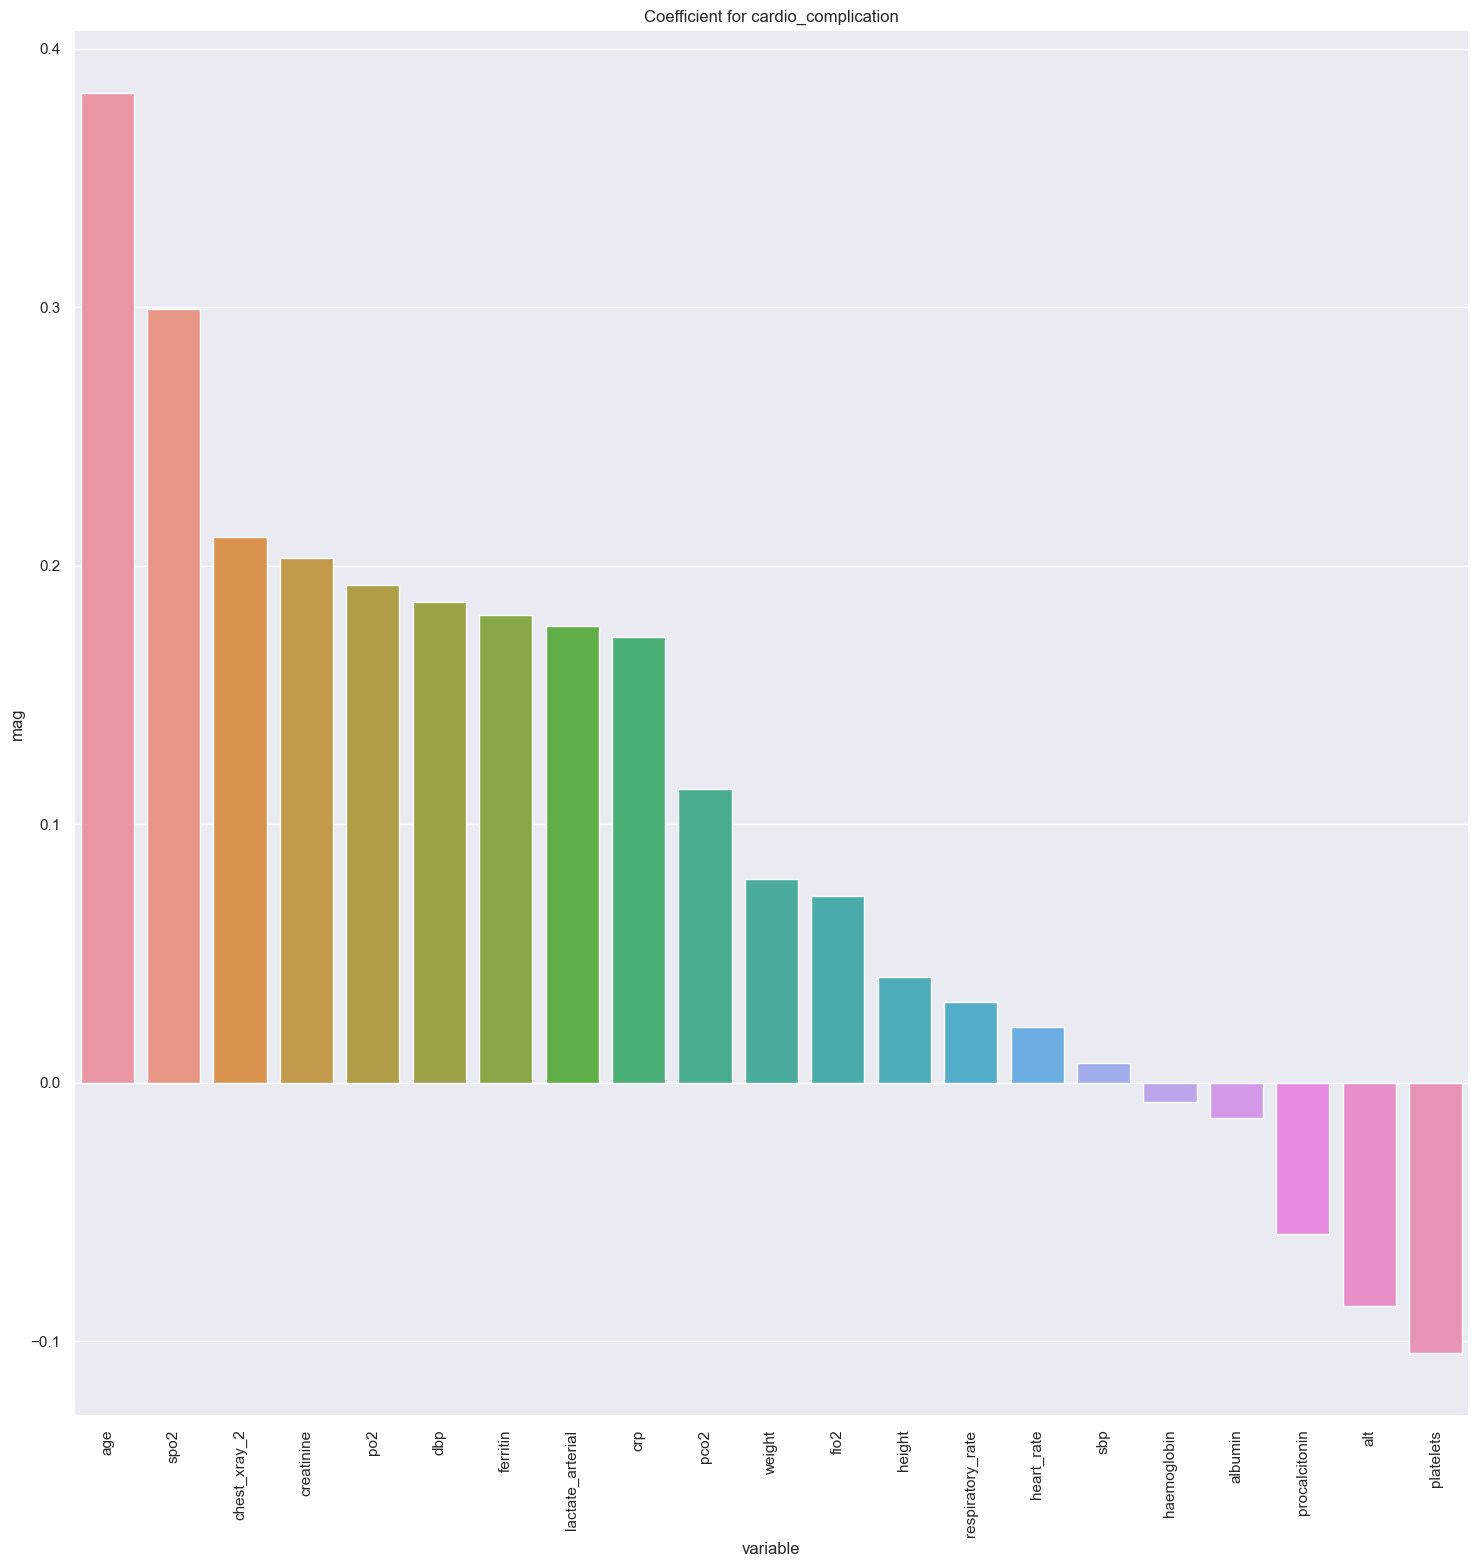

In [19]:
for p in predictor:
    test = joblib.load("model/logistic_feature_selection_median_impute"+p+".pickle")
    feature_select = test.steps[2][1].support_
    coefs = test.steps[3][1].coef_
    coef_df = pd.DataFrame(data = {'variable' : X.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/logistic_feature_selection_median_impute"+p+".png",bbox_inches="tight")

In [20]:
for p in predictor:
    y = df_dummy[p]
    y_train = y.iloc[train]
    test = joblib.load("model/logistic_feature_selection_median_impute"+p+".pickle")
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
         ("scaler", StandardScaler()), 
        ("logistic",LogisticRegression(**test.steps[3][1].get_params()))])

    feature_select = test.named_steps["feature_select"].support_
    tmp_df = pd.DataFrame.from_dict({'model': ['logistic_median'],
               'outcome': [p],
               'accuracy': [np.mean(cross_val_score(test_pipe, X_train.loc[:,feature_select], y_train, cv=5))]})
    score_df = pd.concat([score_df,tmp_df],ignore_index=True)

In [21]:
score_df.to_csv("result/outcome.csv")

In [22]:
for p in predictor:

    test = joblib.load("model/logistic_feature_selection_median_impute"+p+".pickle")
    feature_select = test.named_steps["feature_select"].support_
    temp = test.named_steps["imputer"].transform(X_train)
    temp = test.named_steps["scaler"].transform(temp)

    y = df_dummy[p]
    y_train = y.iloc[train]

    binonmial_model = sm.GLM(y_train, sm.add_constant(temp[:,feature_select]).astype(float), family=sm.families.Binomial())
    res = binonmial_model.fit()

    print(res.summary(xname = ['const'] +  list(X_train.columns[feature_select])))

    with open('result/logistic_feature_selection_median_impute'+p+'_summary.csv', 'w') as fh:
        fh.write(res.summary(xname = ['const'] +  list(X_train.columns[feature_select])).as_csv())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       intubation_dummy   No. Observations:                 1371
Model:                            GLM   Df Residuals:                     1349
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -319.83
Date:                Fri, 01 Sep 2023   Deviance:                       639.66
Time:                        10:45:13   Pearson chi2:                 1.55e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1193
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## L2 logistic regression

In [23]:
score_df = pd.read_csv("result/outcome.csv",index_col=0)

In [24]:

pipeline = Pipeline(steps=[
    ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
    ("scaler", StandardScaler()), 
    ("logistic", LogisticRegression(random_state=random_seed,max_iter = 1000,penalty = 'l2',n_jobs=4,solver = 'lbfgs'))])

param_grid = {
    "logistic__C": np.logspace(1e-2,1e2,num=10)
}

grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5)

In [25]:
for p in predictor:
    y = df_dummy[p]
    X = df_dummy.drop(predictor, axis=1)
    X_train= X.iloc[train,:]
    y_train = y.iloc[train]
    grid.fit(X_train, y_train)
    
    pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = 'l2',
                                                      C = grid.best_params_["logistic__C"]), n_features_to_select='auto')),
        ("logistic",LogisticRegression(max_iter = 1000,penalty = 'l2',C = grid.best_params_["logistic__C"]))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/logistic_l2_feature_selection_median_impute_"+p+".pickle")

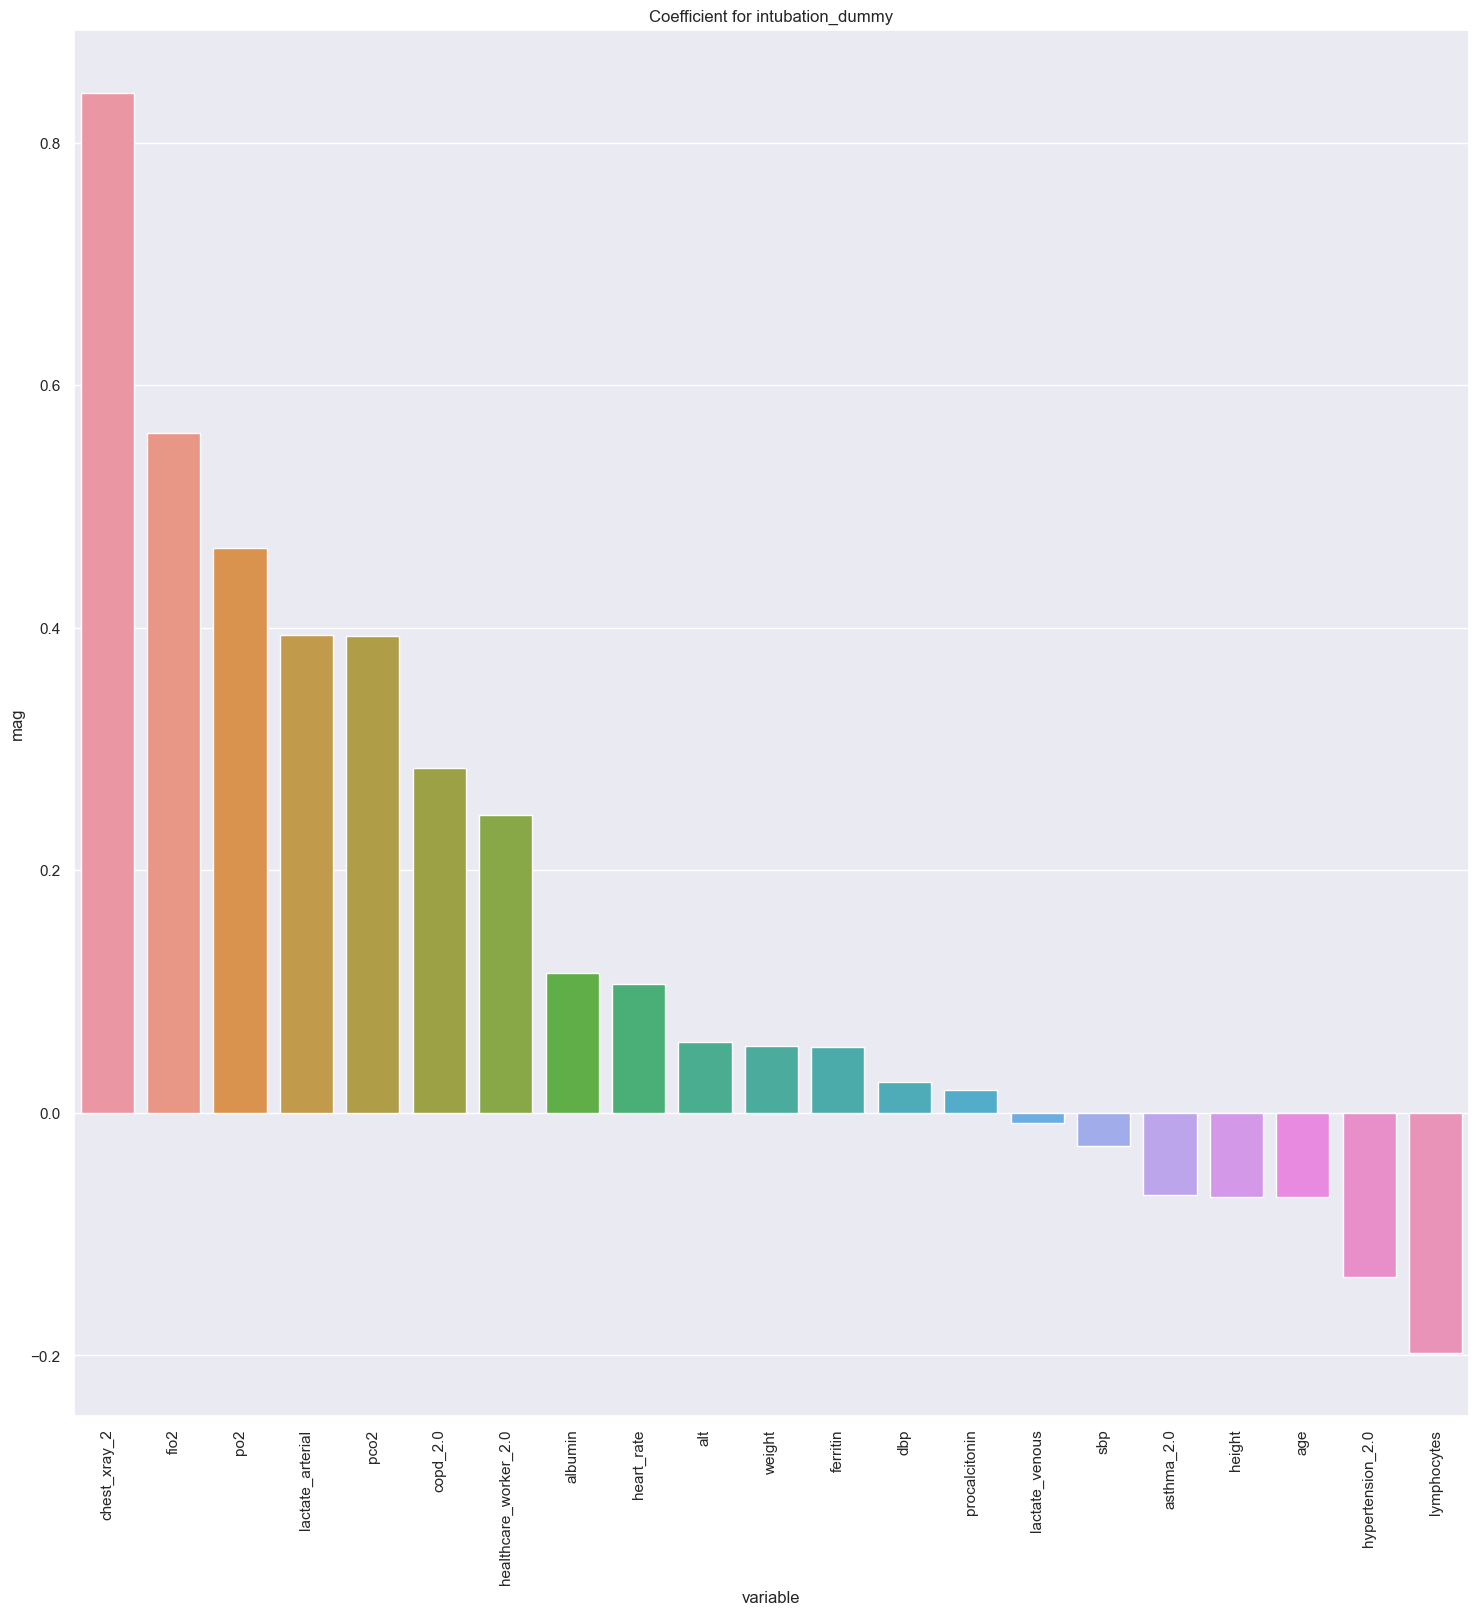

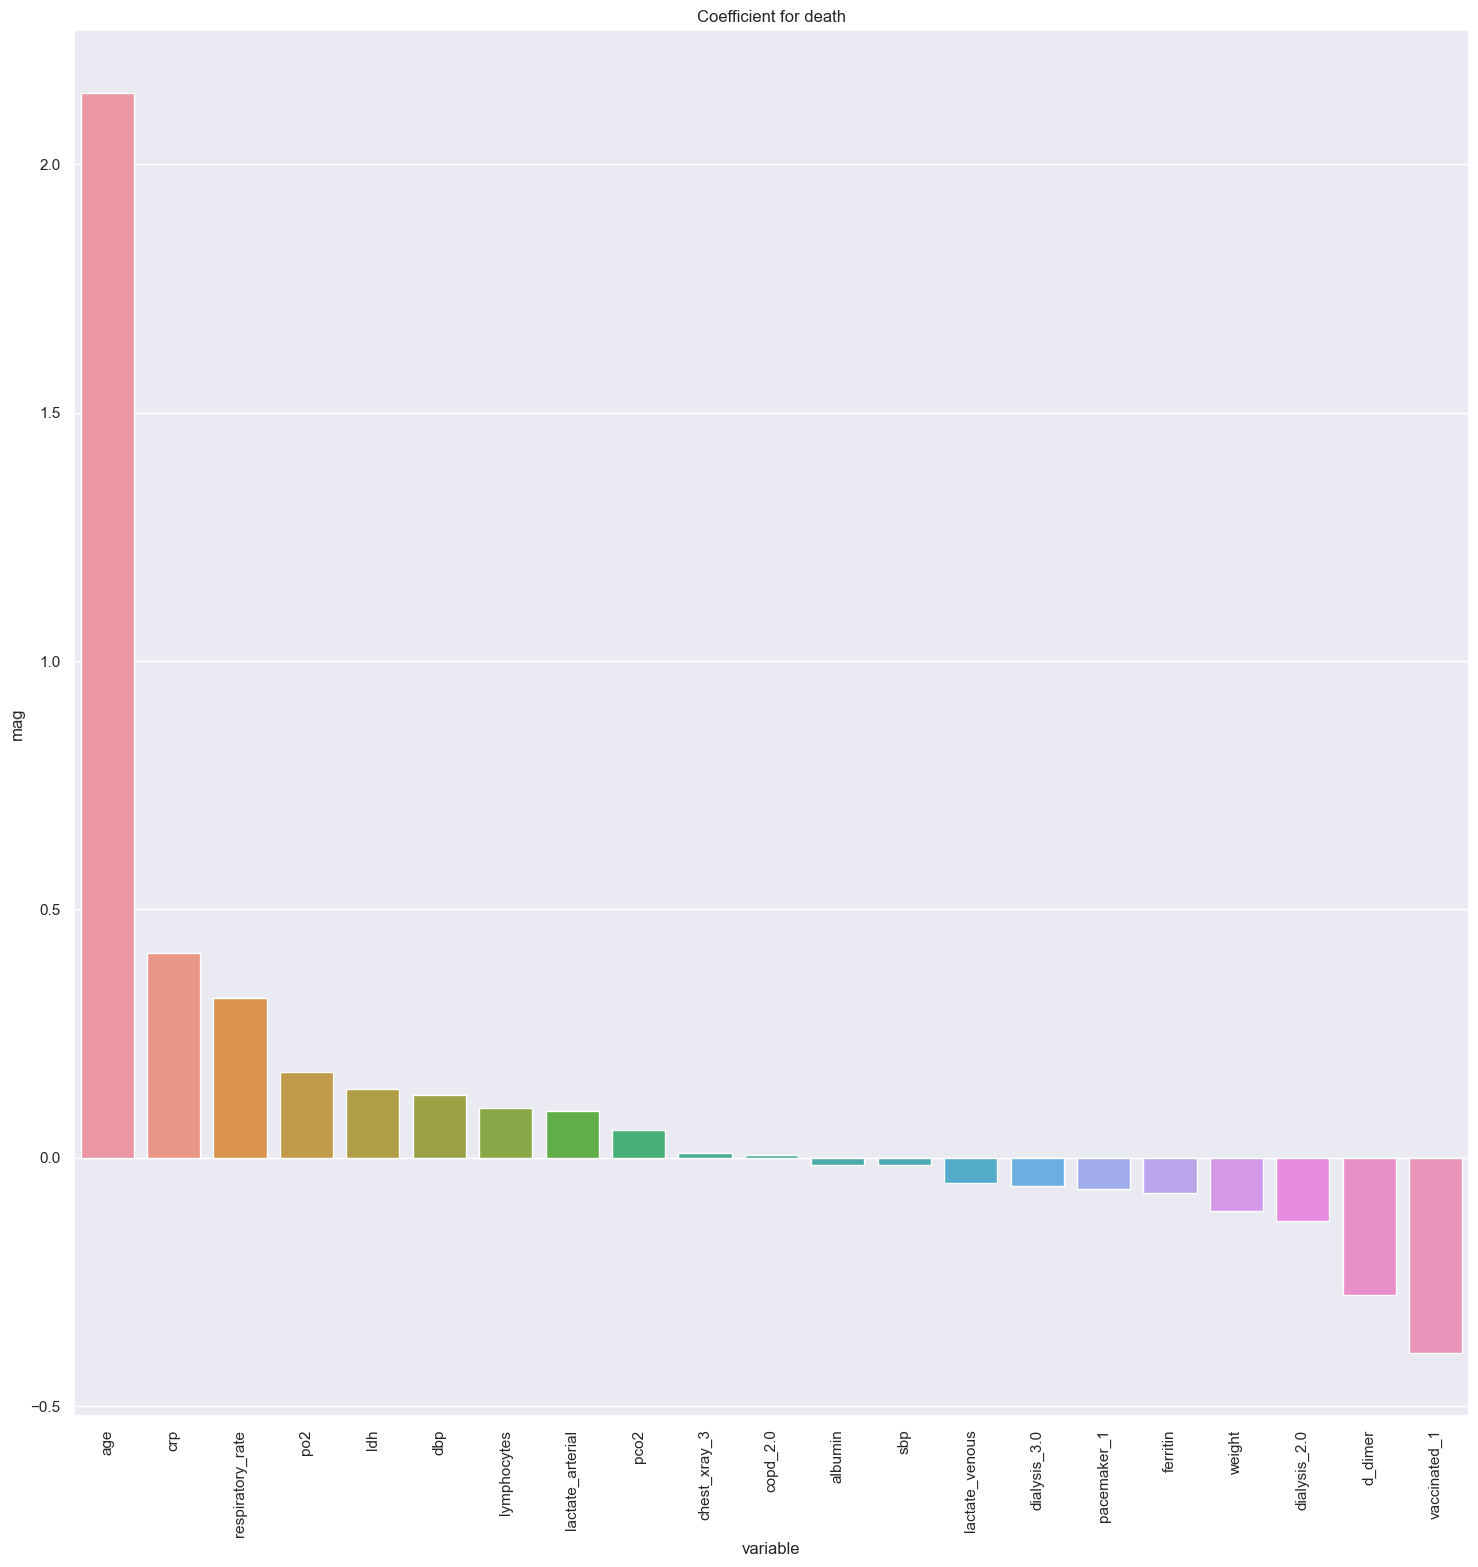

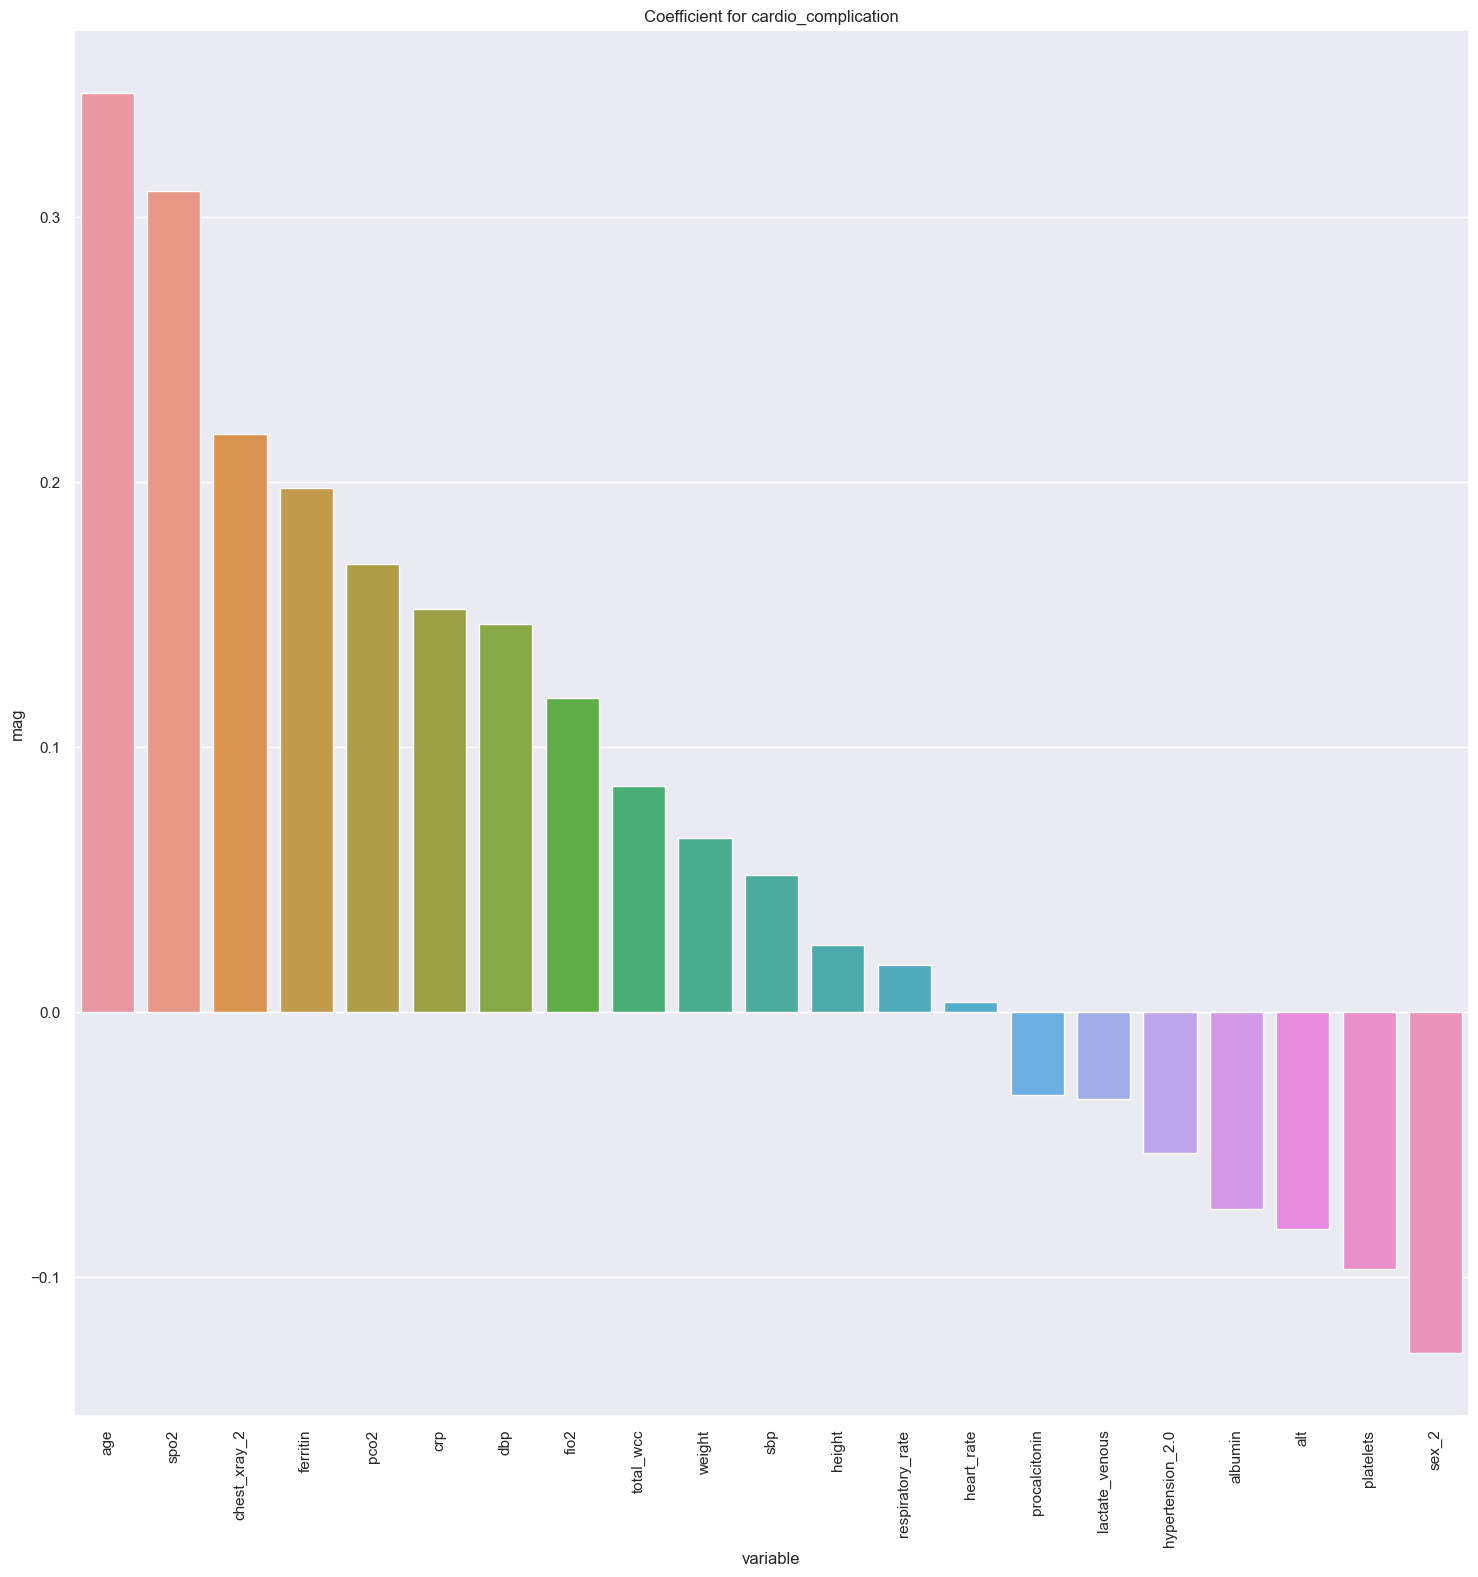

In [26]:
for p in predictor:
    test = joblib.load("model/logistic_l2_feature_selection_median_impute_"+p+".pickle")
    feature_select = test.named_steps["feature_select"].support_
    coefs = test.named_steps["logistic"].coef_
    coef_df = pd.DataFrame(data = {'variable' : X.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/logistic_l2_feature_selection_median_impute_"+p+".png",bbox_inches="tight")

In [27]:
for p in predictor:
    y = df_dummy[p]
    y_train = y.iloc[train]
    test = joblib.load("model/logistic_l2_feature_selection_median_impute_"+p+".pickle")
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
         ("scaler", StandardScaler()), 
       
        ("logistic",LogisticRegression(**test.named_steps["logistic"].get_params()))])
    
    feature_select = test.named_steps["feature_select"].support_
    tmp_df = pd.DataFrame.from_dict({'model': ['logistic+l2_median'],
               'outcome': [p],
               'accuracy': [np.mean(cross_val_score(test_pipe, X_train.loc[:,feature_select], y_train, cv=5))]})
    score_df = pd.concat([score_df,tmp_df],ignore_index=True)

In [28]:
score_df

,model,accuracy,outcome
0,baseline_median_impute,0.916844,intubation_dummy
1,baseline_median_impute,0.895679,death
2,baseline_median_impute,0.944568,cardio_complication
3,logistic_median,0.929980,intubation_dummy
4,logistic_median,0.911743,death
5,logistic_median,0.946755,cardio_complication
6,logistic+l2_median,0.932897,intubation_dummy
7,logistic+l2_median,0.907366,death
8,logistic+l2_median,0.947482,cardio_complication


In [29]:
score_df.to_csv("result/outcome.csv")

## L1 logistic regression

In [30]:
score_df = pd.read_csv("result/outcome.csv",index_col=0)

In [31]:
pipeline = Pipeline(steps=[
    ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
    ("scaler", StandardScaler()), 
    ("logistic", LogisticRegression(random_state=random_seed,max_iter = 10000,penalty = 'l1',n_jobs=4,solver = 'saga'))])

param_grid = {
    "logistic__C": np.logspace(1e-2,1e2,num=10)
}

grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5)

In [32]:
for p in predictor:
    y = df_dummy[p]
    X = df_dummy.drop(predictor, axis=1)
    X_train= X.iloc[train,:]
    y_train = y.iloc[train]
    grid.fit(X_train, y_train)
    
    pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(LogisticRegression(penalty = 'l1',max_iter = 10000,
                                                      C = grid.best_params_["logistic__C"],solver = 'saga')
                                   , n_features_to_select='auto')),
        ("logistic",LogisticRegression(penalty = 'l1',max_iter = 10000,C = grid.best_params_["logistic__C"],solver = 'saga'))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/logistic_l1_feature_selection_median_impute_"+p+".pickle")

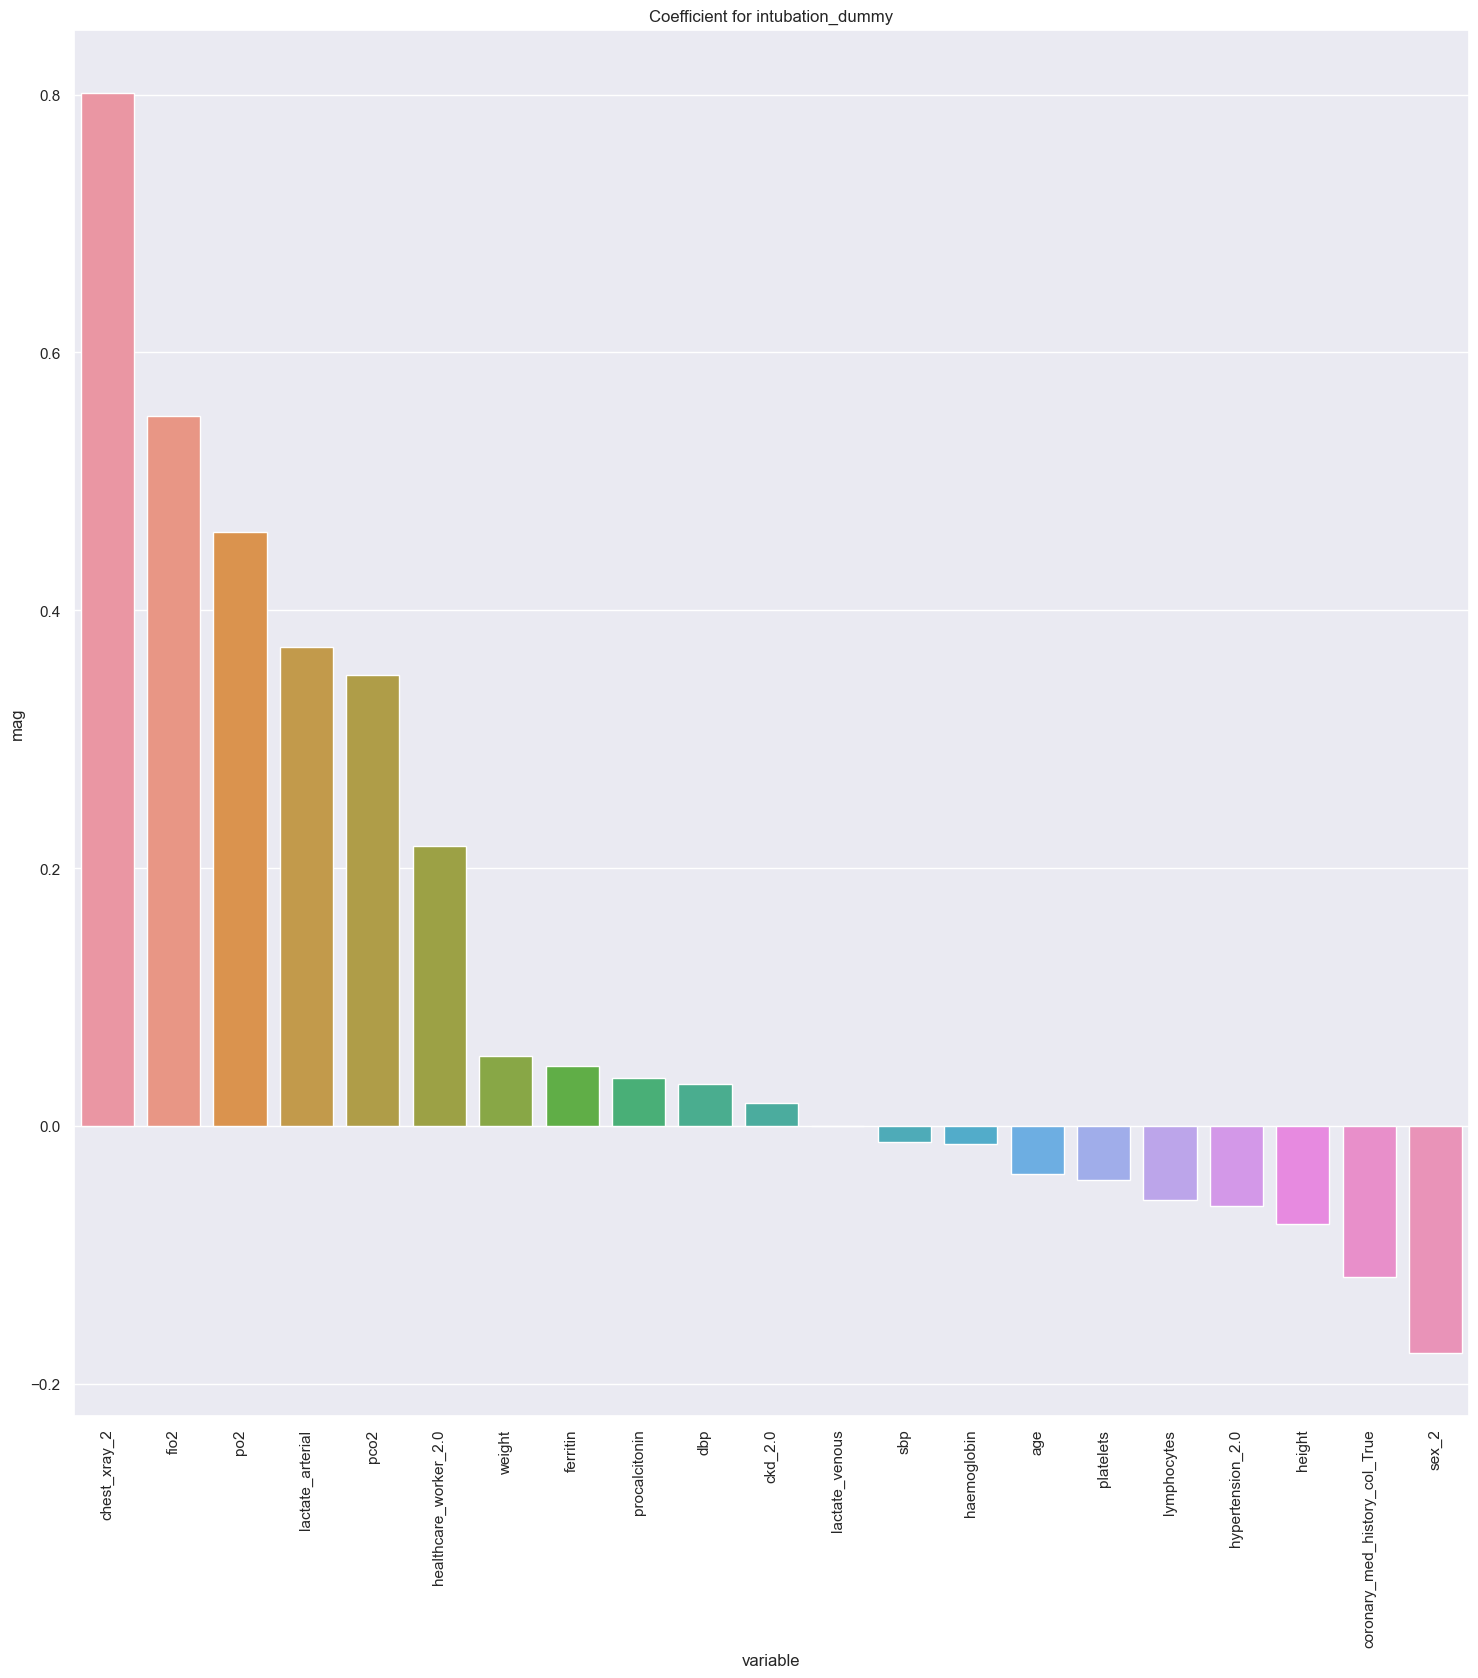

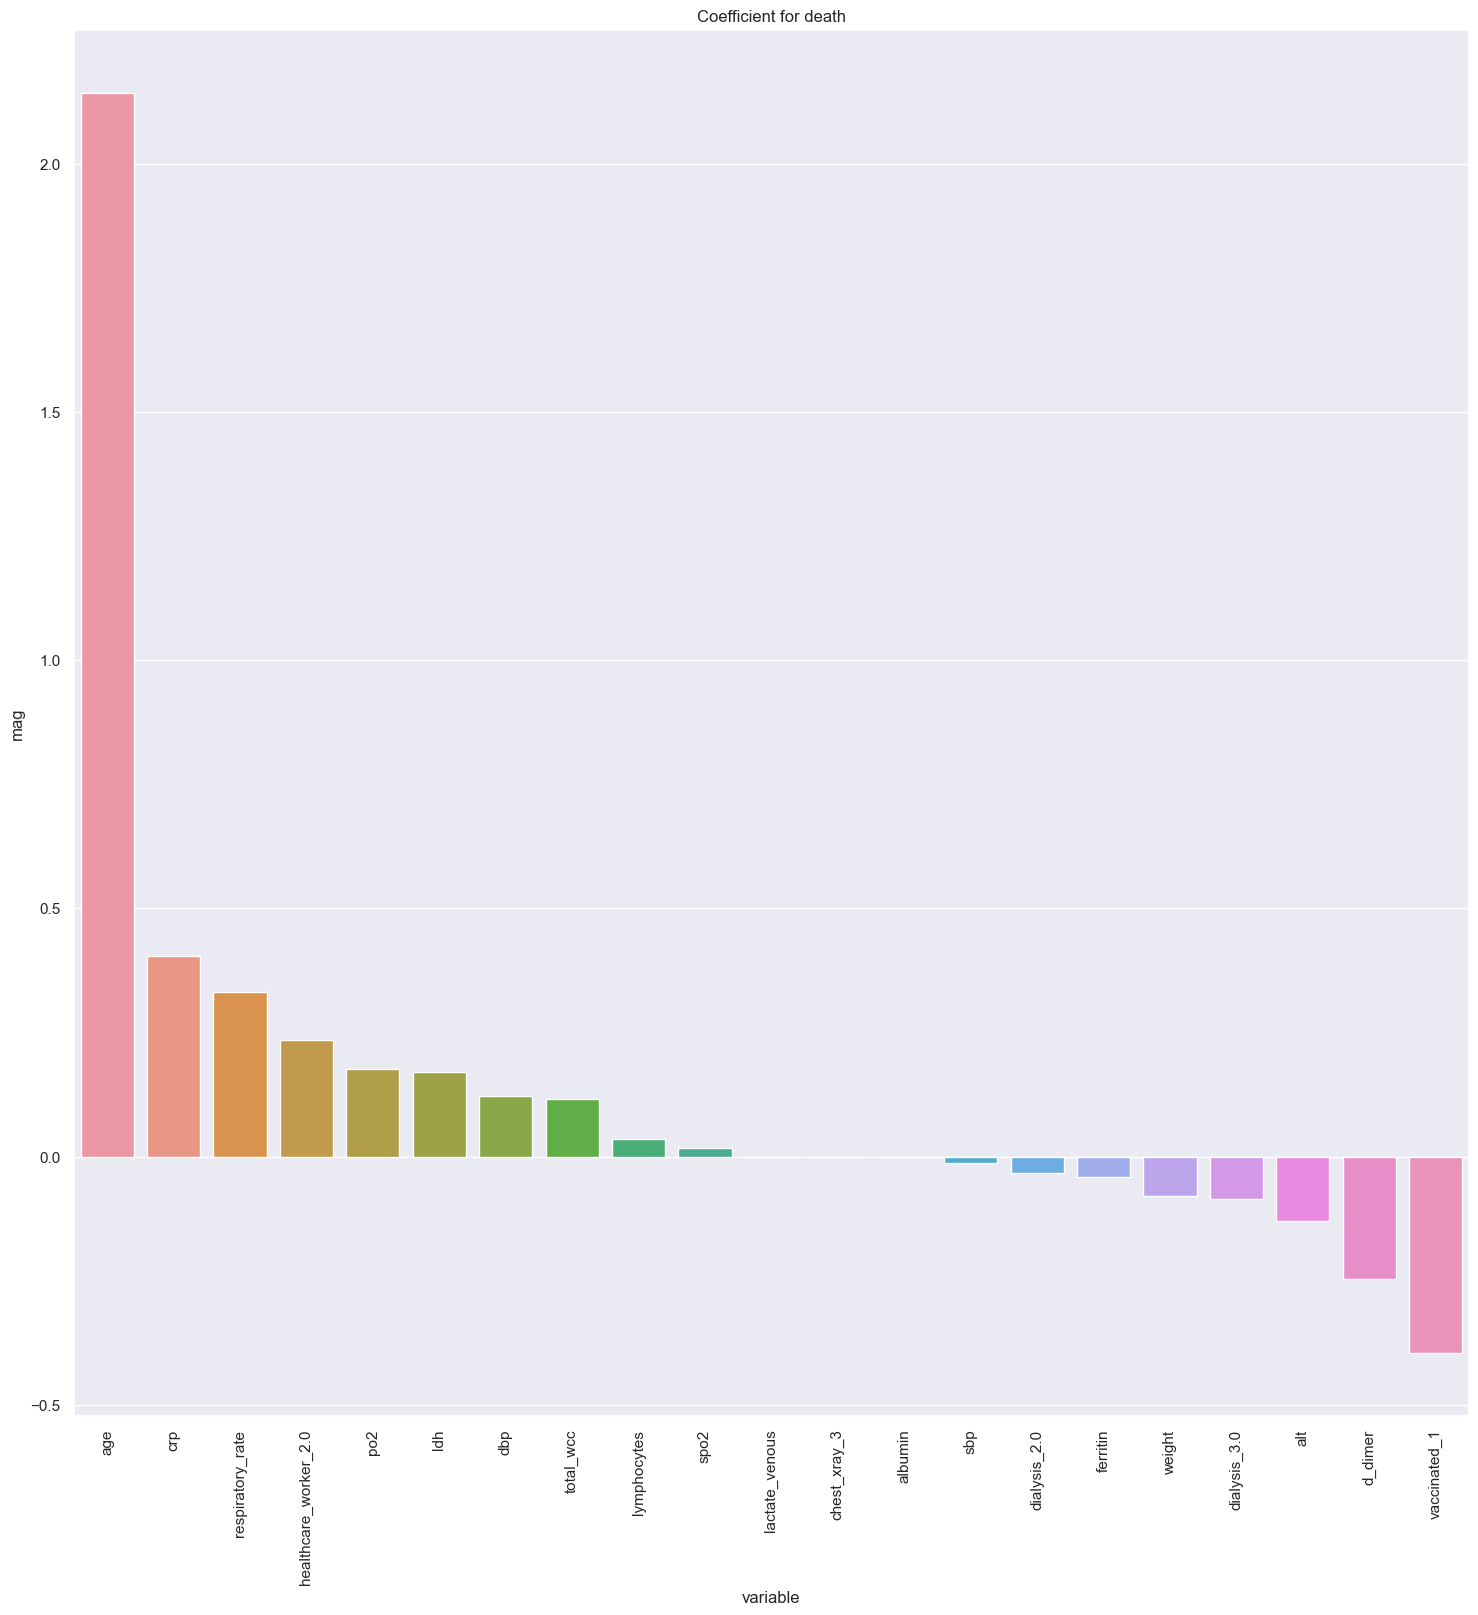

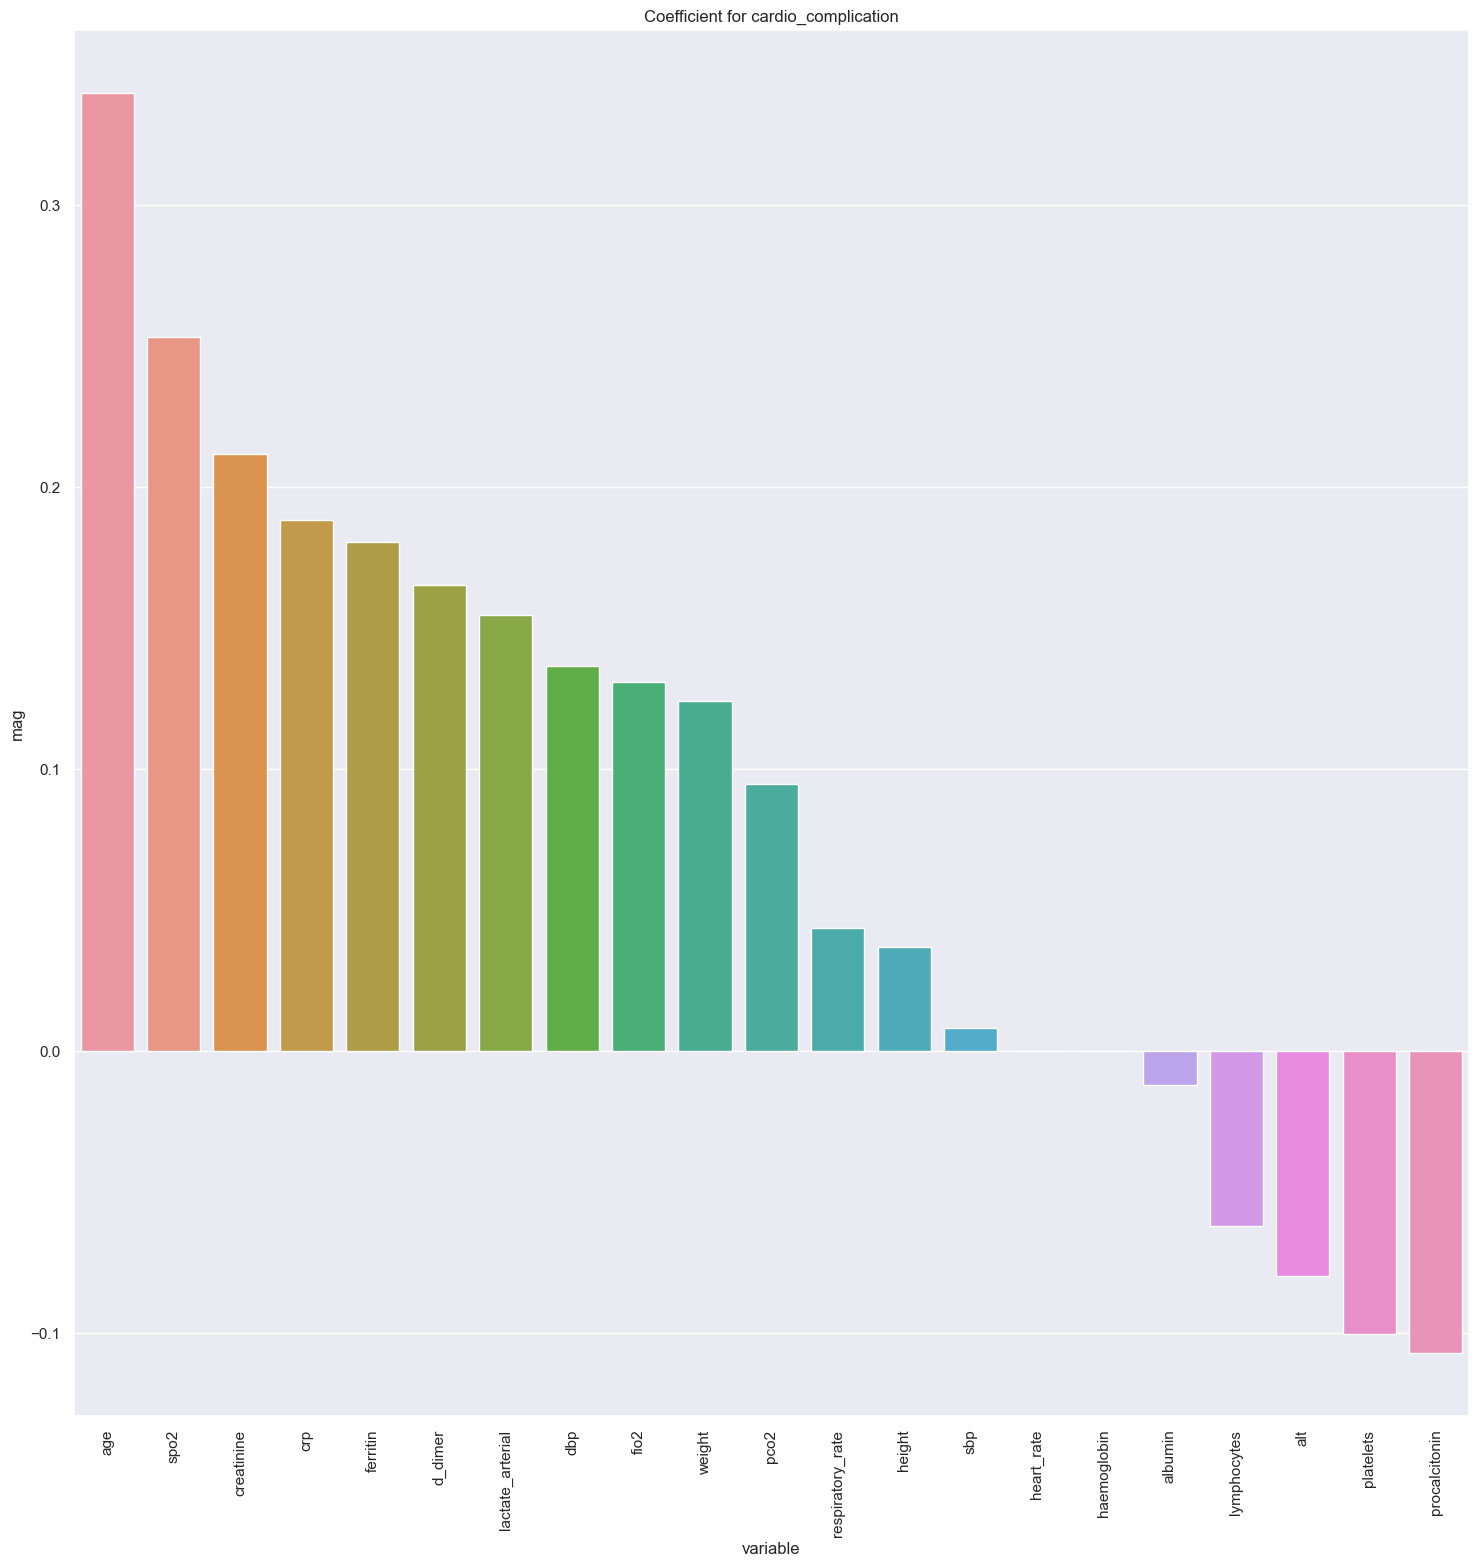

In [34]:
for p in predictor:
    test = joblib.load("model/logistic_l1_feature_selection_median_impute_"+p+".pickle")
    feature_select = test.named_steps["feature_select"].support_
    coefs = test.named_steps["logistic"].coef_
    coef_df = pd.DataFrame(data = {'variable' : X.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.savefig("figure/logistic_l1_feature_selection_median_impute_"+p+".png",bbox_inches="tight")

In [35]:
for p in predictor:
    y = df_dummy[p]
    y_train = y.iloc[train]
    test = joblib.load("model/logistic_l1_feature_selection_median_impute_"+p+".pickle")
    test_pipe = Pipeline(steps=[
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
         ("scaler", StandardScaler()), 
       
        ("logistic",LogisticRegression(**test.named_steps["logistic"].get_params()))])
    feature_select = test.named_steps["feature_select"].support_
    tmp_df = pd.DataFrame.from_dict({'model': ['logistic+l1_median'],
               'outcome': [p],
               'accuracy': [np.mean(cross_val_score(test_pipe, X_train.loc[:,feature_select], y_train, cv=5))]})
    score_df = pd.concat([score_df,tmp_df],ignore_index=True)

In [37]:
score_df.to_csv("result/outcome.csv")

## decision tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
score_df = pd.read_csv("result/outcome.csv",index_col=0)

In [34]:
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()), 
    ("tree", DecisionTreeClassifier(random_state=random_seed))])

param_grid = {
    "tree__criterion": ['gini', 'entropy'],
    'tree__min_samples_split':np.linspace(0.02,0.3,num=10) 
}

grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5)

In [37]:
for p in predictor:
    y = df_dummy[p]
    X = df_dummy.drop(predictor, axis=1)
    X_train= X.iloc[train,:]
    y_train = y.iloc[train]
    grid.fit(X_train, y_train)
    
    pipe = Pipeline(steps=[
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(
             DecisionTreeClassifier(
                 criterion = grid.best_params_["tree__criterion"],
                 min_samples_split = grid.best_params_["tree__min_samples_split"])
            ,n_features_to_select=15)),
        ("logistic",
         DecisionTreeClassifier(
                 criterion = grid.best_params_["tree__criterion"],
                 min_samples_split = grid.best_params_["tree__min_samples_split"]))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/decision_tree_feature_selection_"+p+".pickle")

In [38]:
for p in predictor:
    test = joblib.load("model/decision_tree_feature_selection_"+p+".pickle")
    test_pipe = make_pipeline(
        StandardScaler(), 
        DecisionTreeClassifier(**test.steps[2][1].get_params()))
    feature_select = test.steps[1][1].support_
    tmp_df = pd.DataFrame.from_dict({'model': ['decision_tree'],
               'outcome': [p],
               'accuracy': [np.mean(cross_val_score(test_pipe, X_train.loc[:,feature_select], y_train, cv=5))]})
    score_df = pd.concat([score_df,tmp_df],ignore_index=True)

In [42]:
score_df.to_csv("result/outcome.csv")

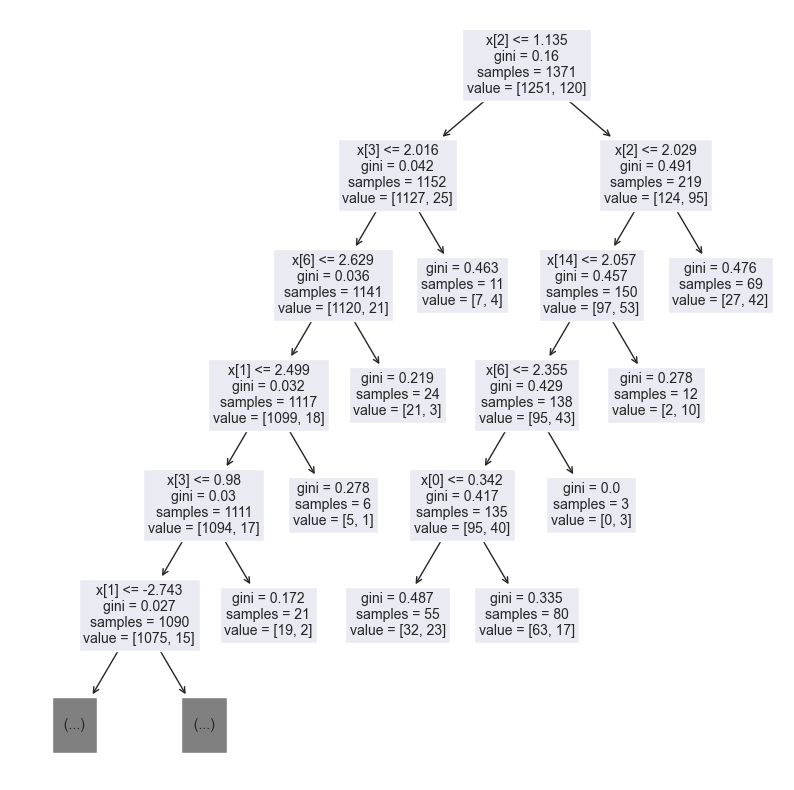

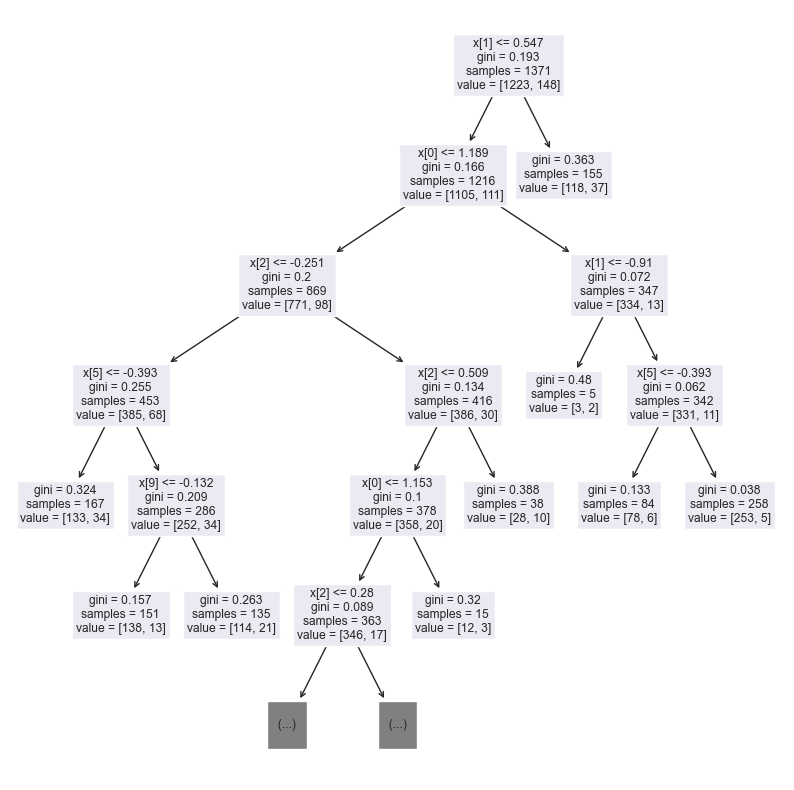

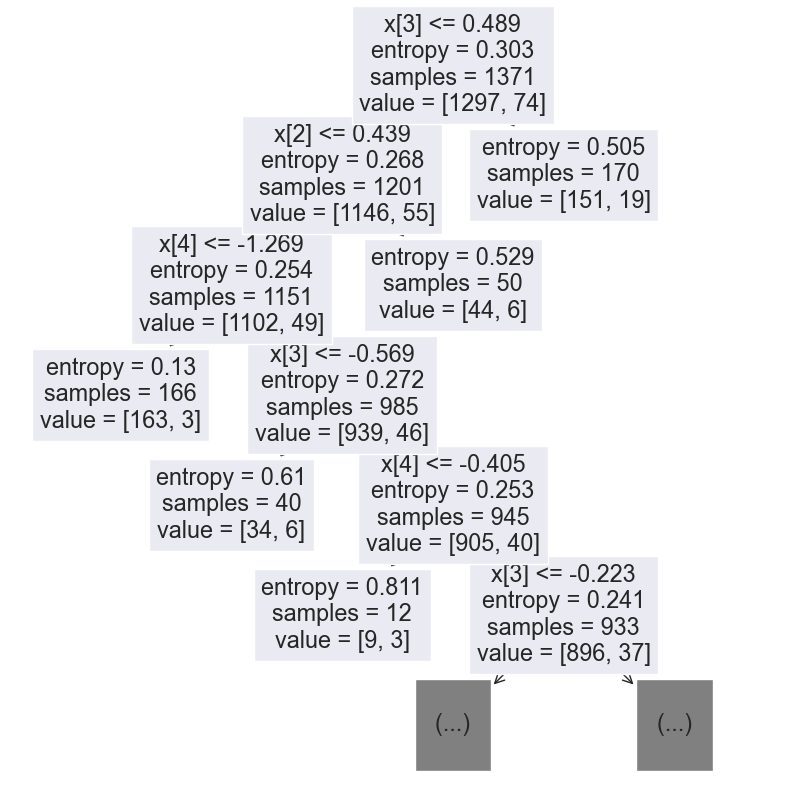

In [40]:
from sklearn.tree import plot_tree
for p in predictor:
    test = joblib.load("model/decision_tree_feature_selection_"+p+".pickle")
    plt.figure(figsize=(10, 10))
    plot_tree(test.steps[2][1],max_depth = 5)

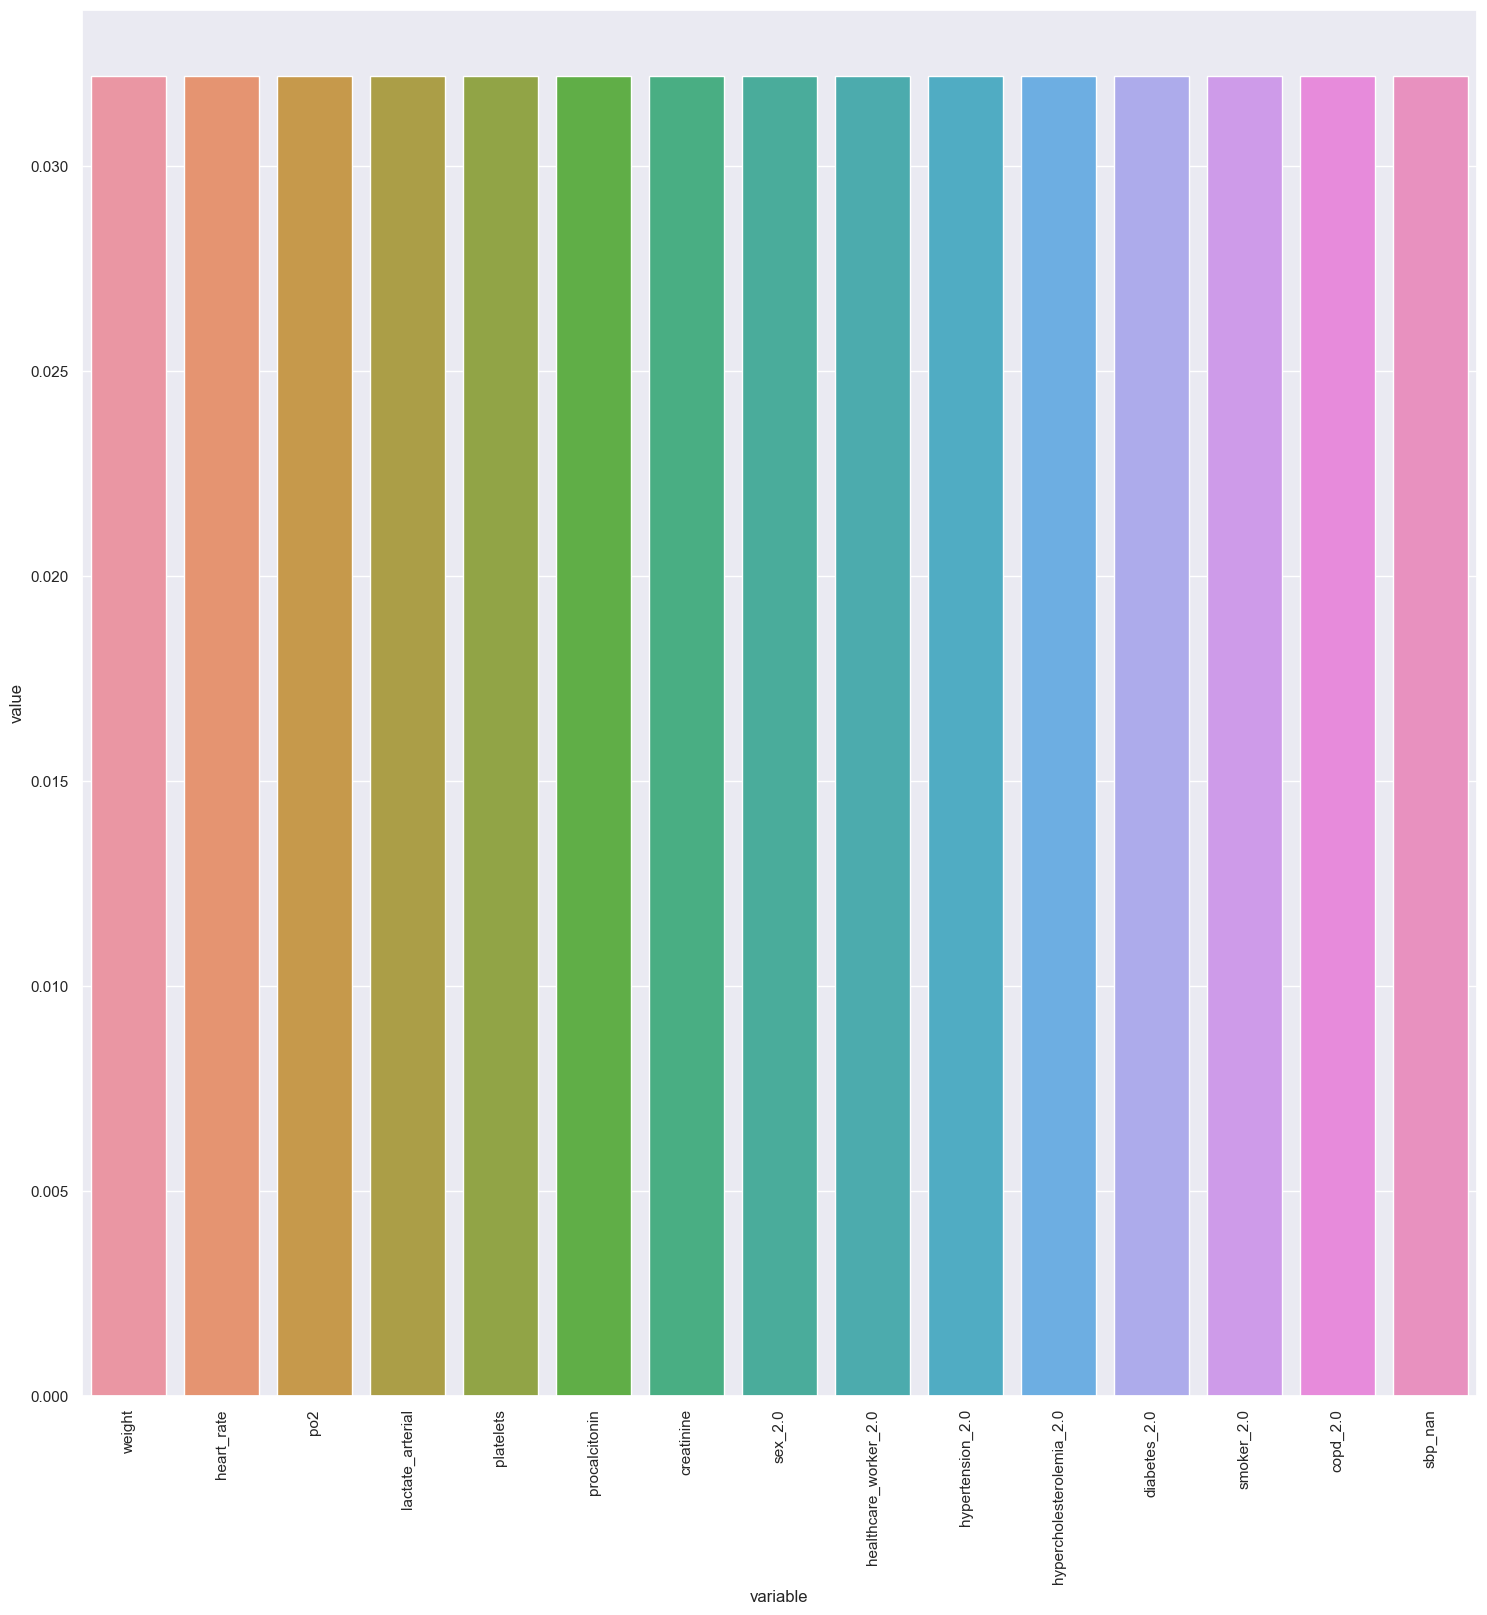

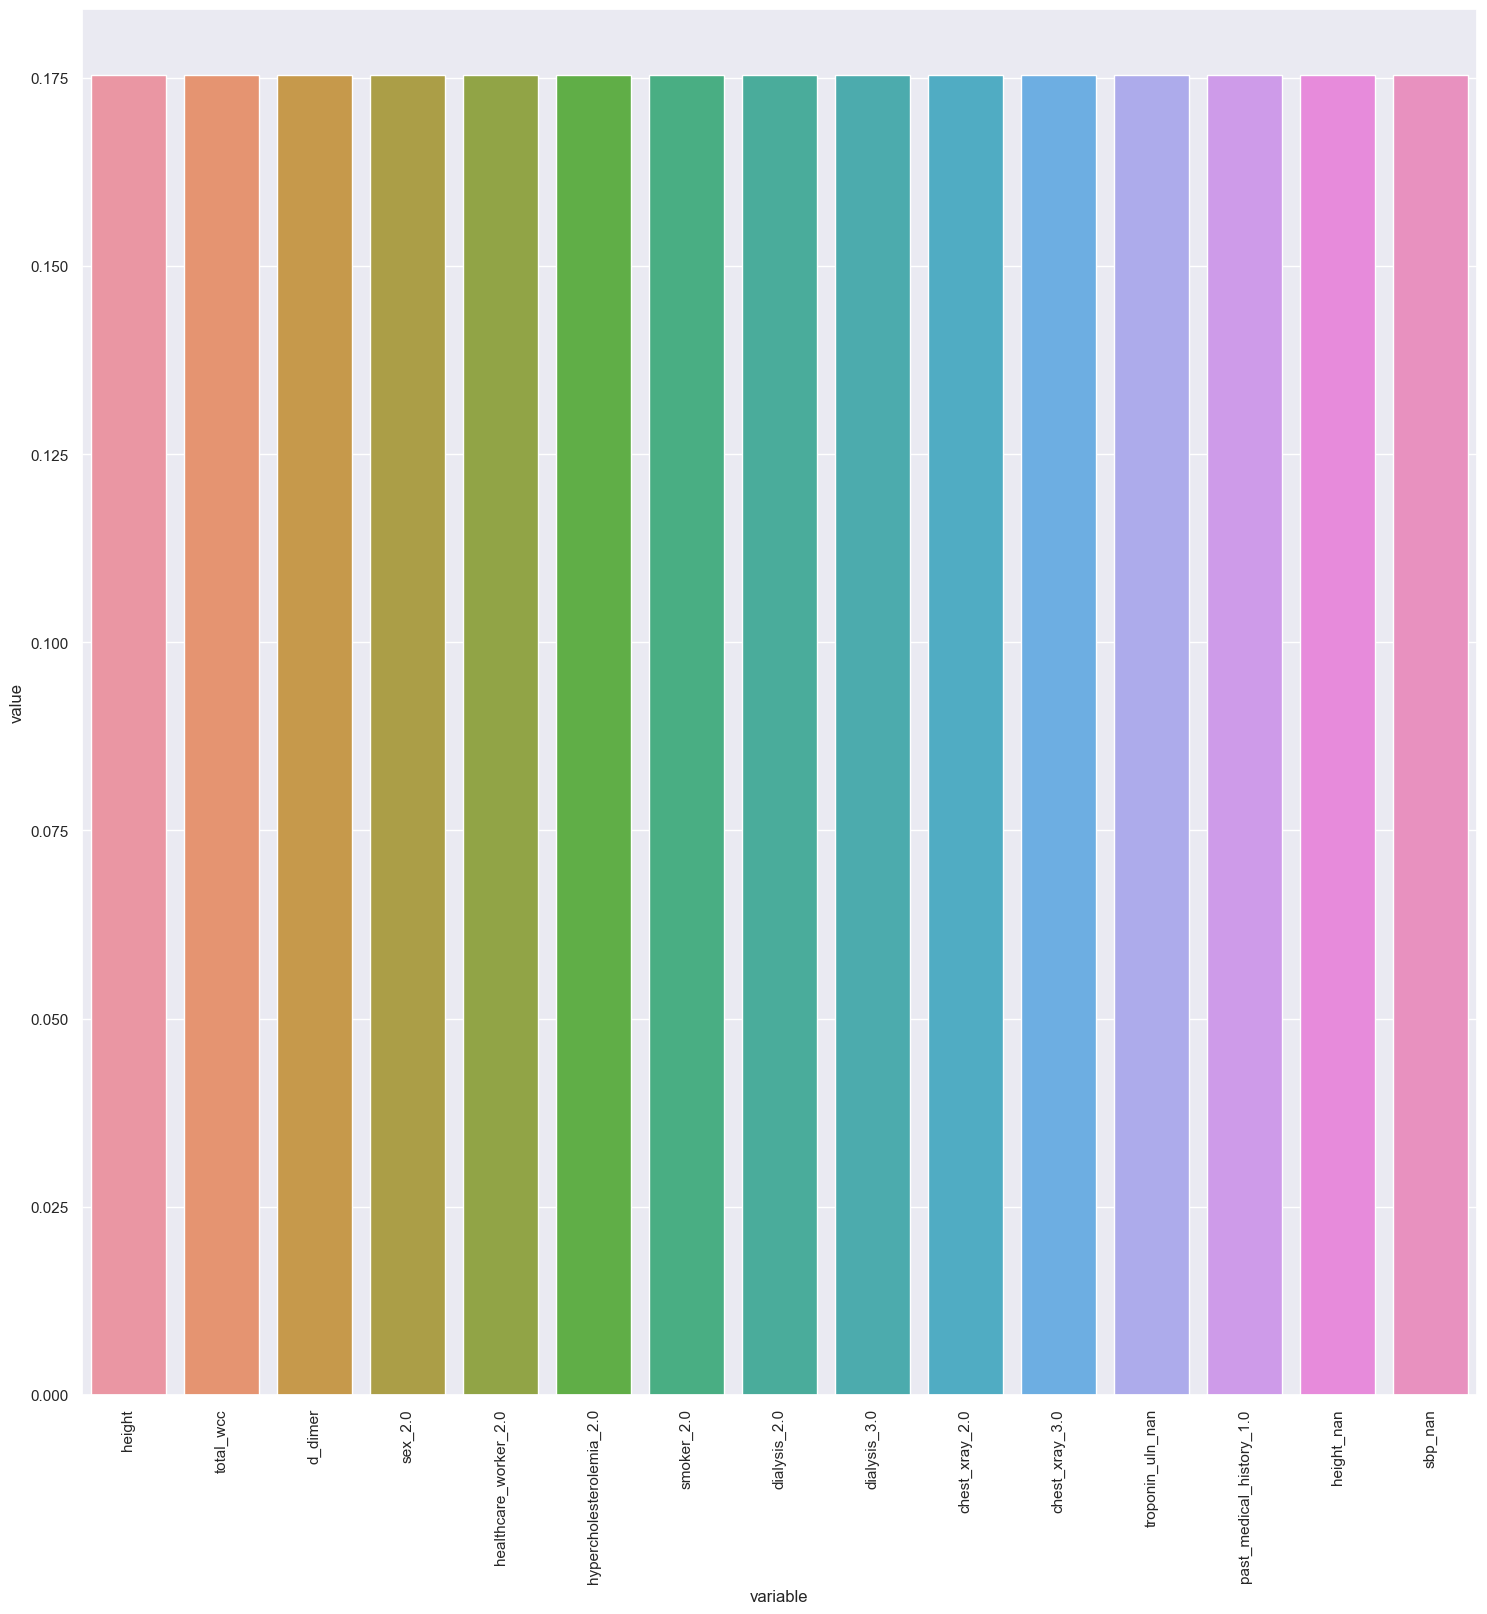

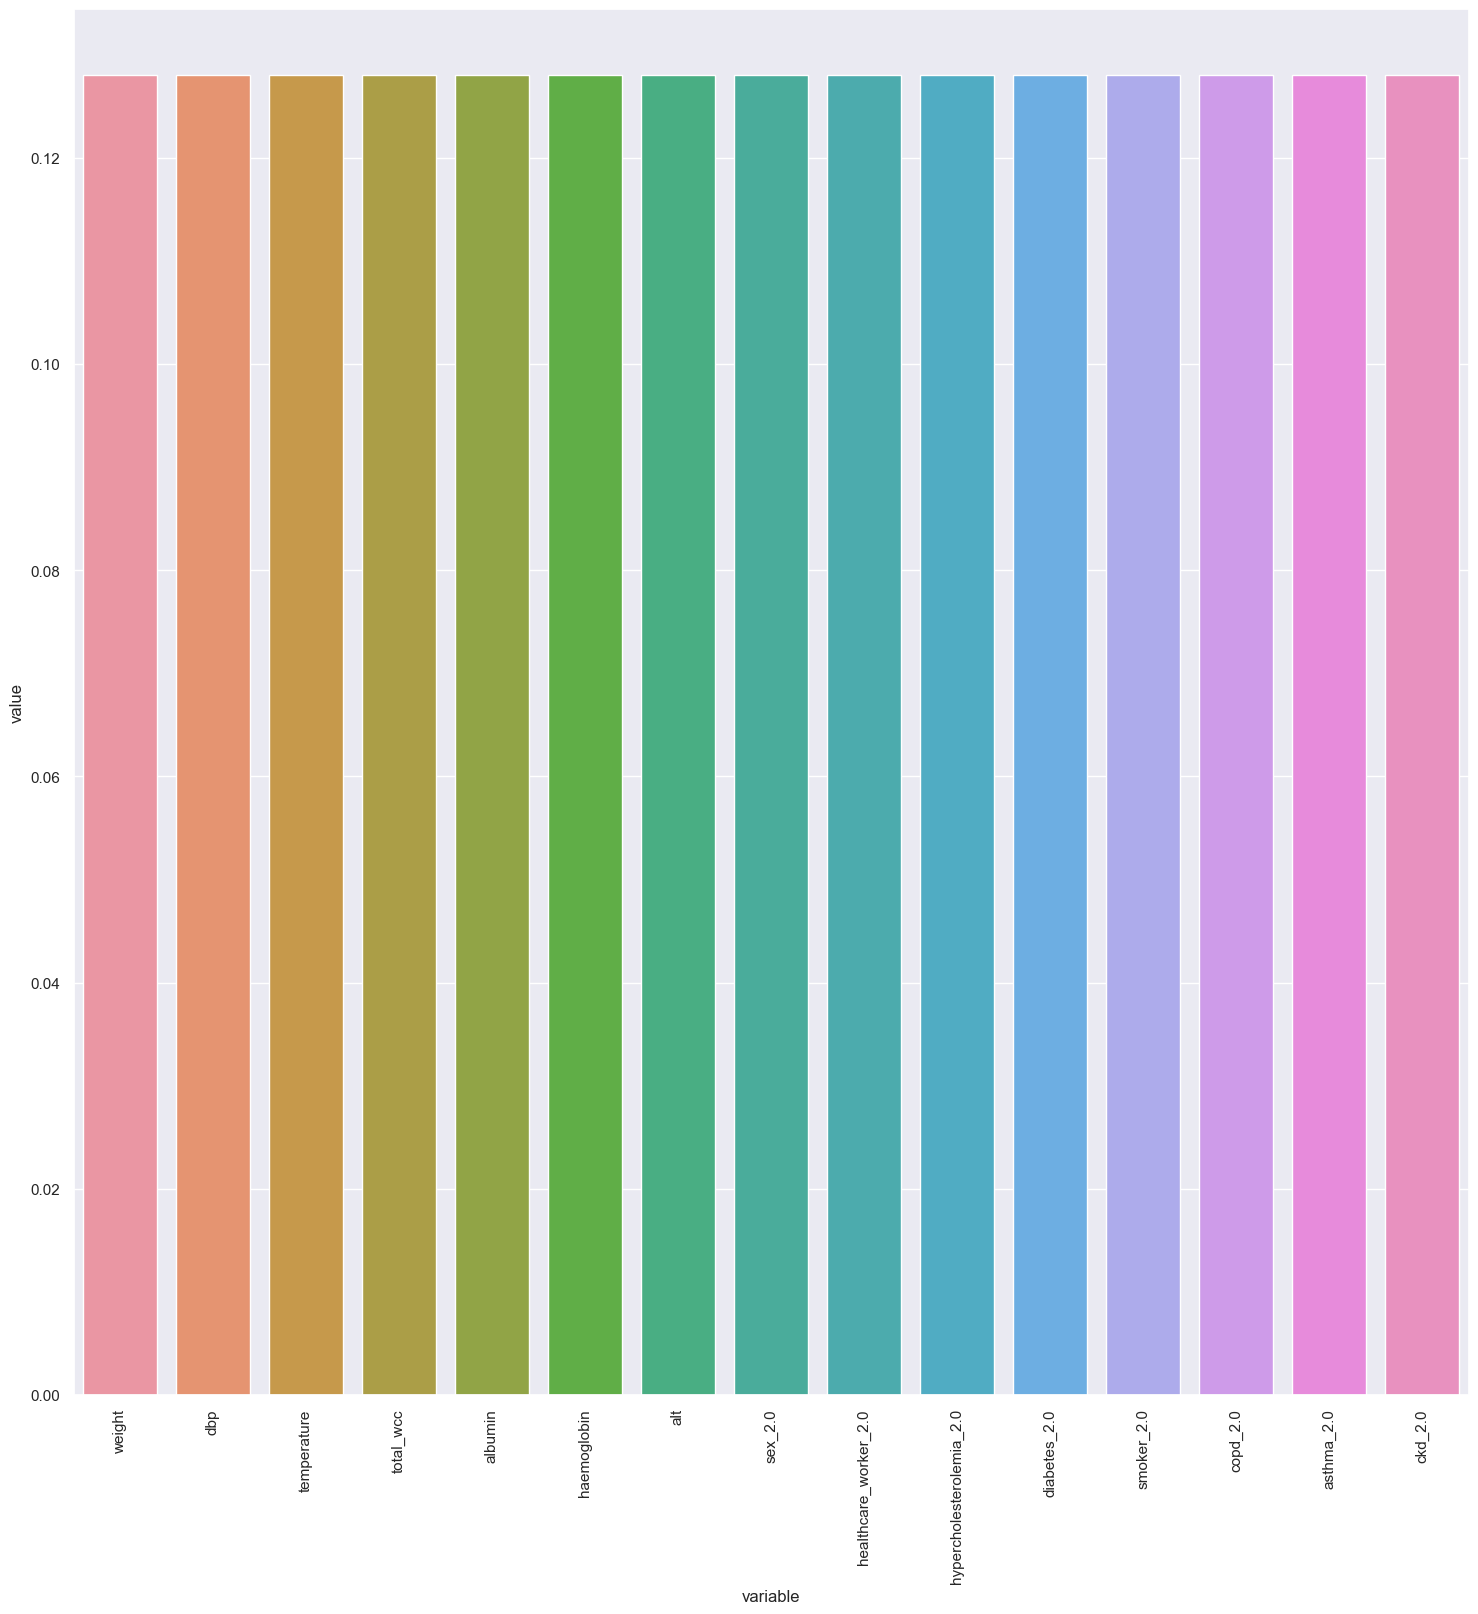

In [41]:
for p in predictor:
    test = joblib.load("model/decision_tree_feature_selection_"+p+".pickle")
    feature_select = test.steps[1][1].support_
    coefs = test.steps[2][1].feature_importances_
    
    coef_df = pd.DataFrame(data = {'variable' : X.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('value', ascending=False)
    plt.figure(figsize=(18, 18))
    sns.barplot(
        data=coef_df, x="variable", y="value")
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=90)

In [43]:
for p in predictor:
    y = df_dummy[p]
    X = df_dummy.drop(predictor, axis=1)
    X_train= X.iloc[train,:]
    y_train = y.iloc[train]
    grid.fit(X_train, y_train)
    
    pipe = Pipeline(steps=[
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(
             DecisionTreeClassifier(
                 criterion = grid.best_params_["tree__criterion"],
                 min_samples_split = grid.best_params_["tree__min_samples_split"])
            ,n_features_to_select='auto')),
        ("logistic",
         DecisionTreeClassifier(
                 criterion = grid.best_params_["tree__criterion"],
                 min_samples_split = grid.best_params_["tree__min_samples_split"]))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/decision_tree_full_feature_selection_"+p+".pickle")

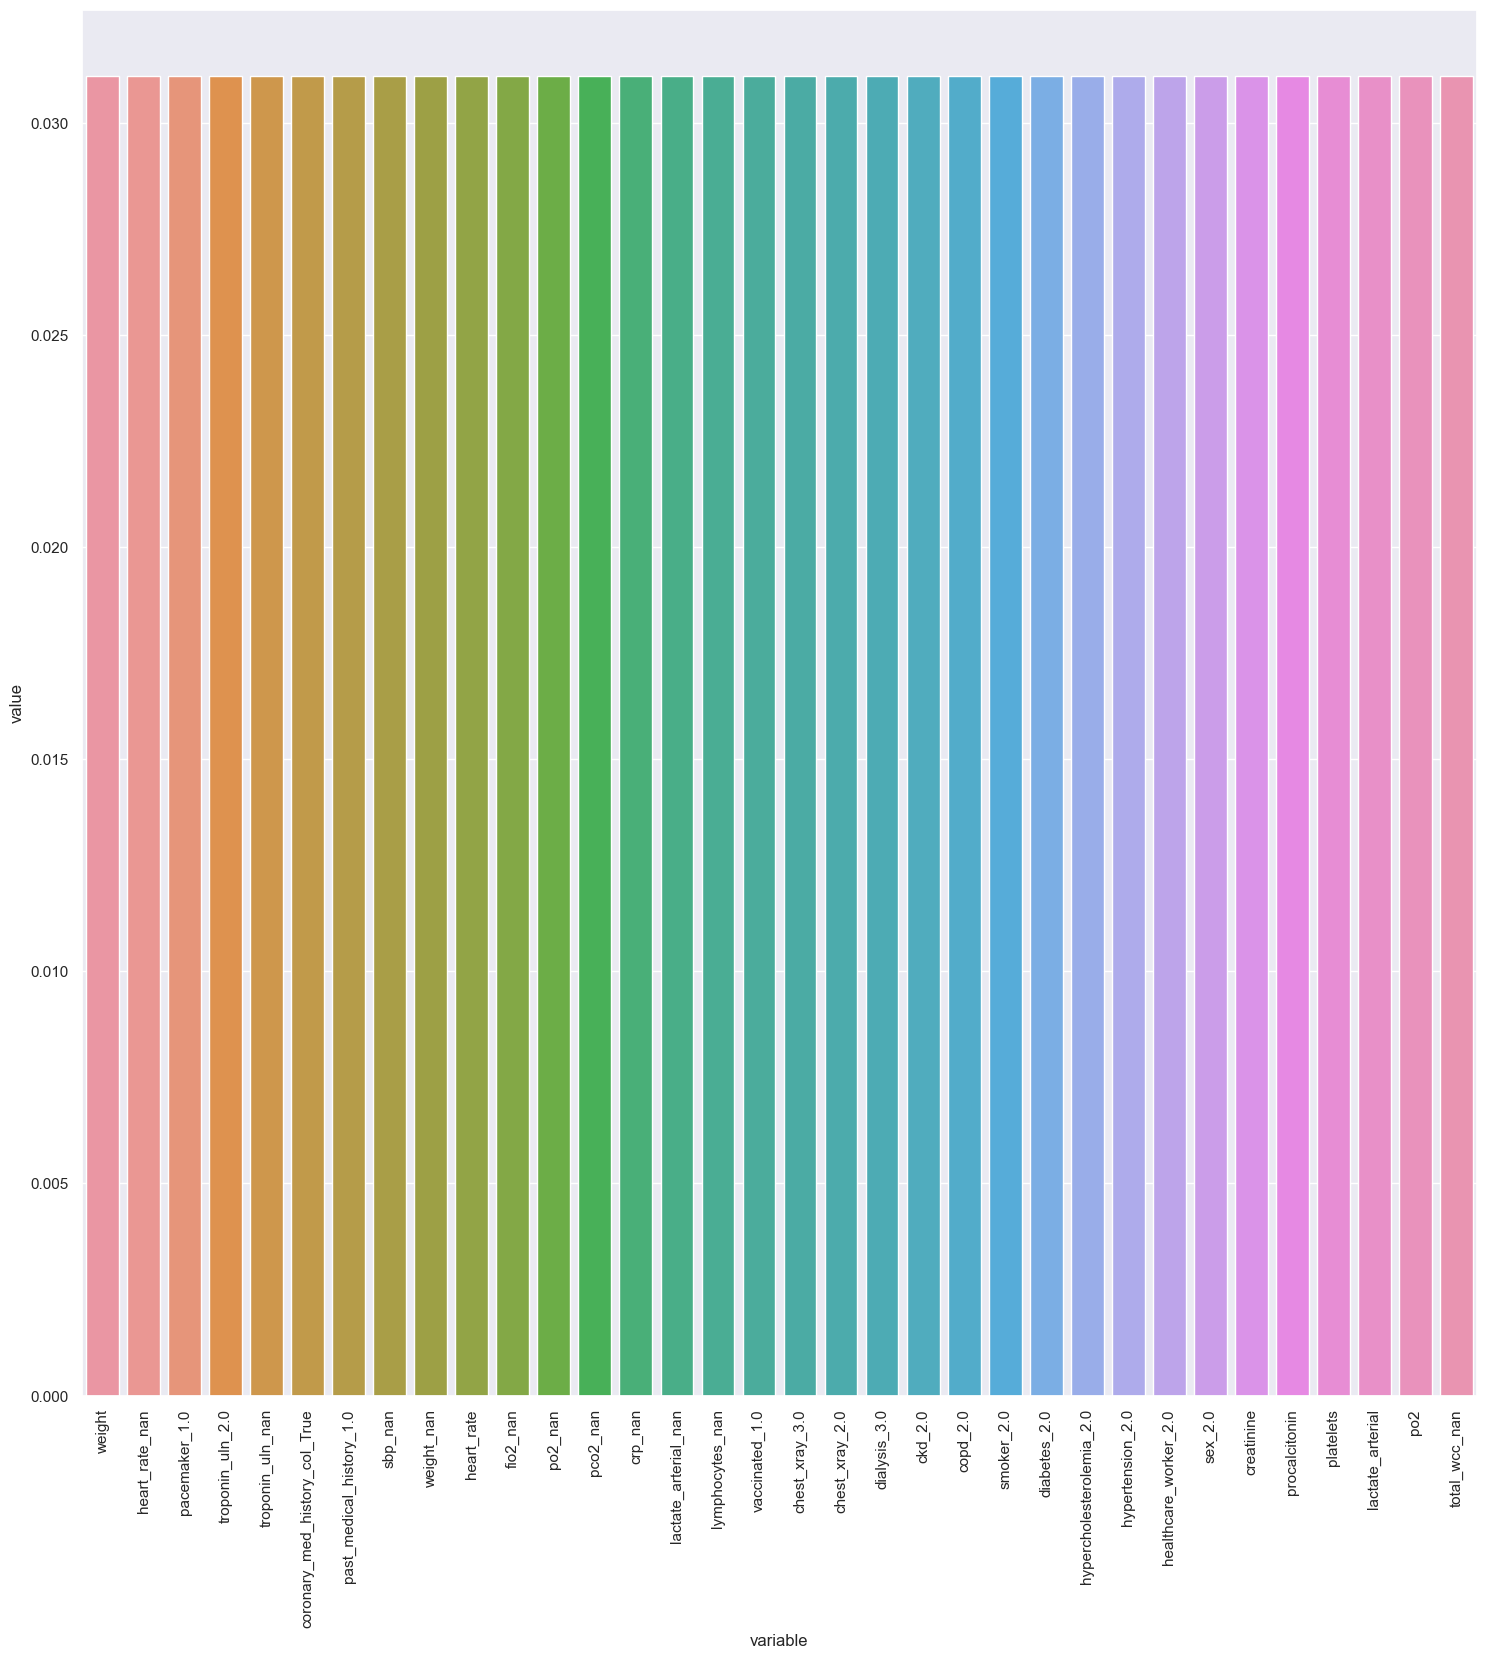

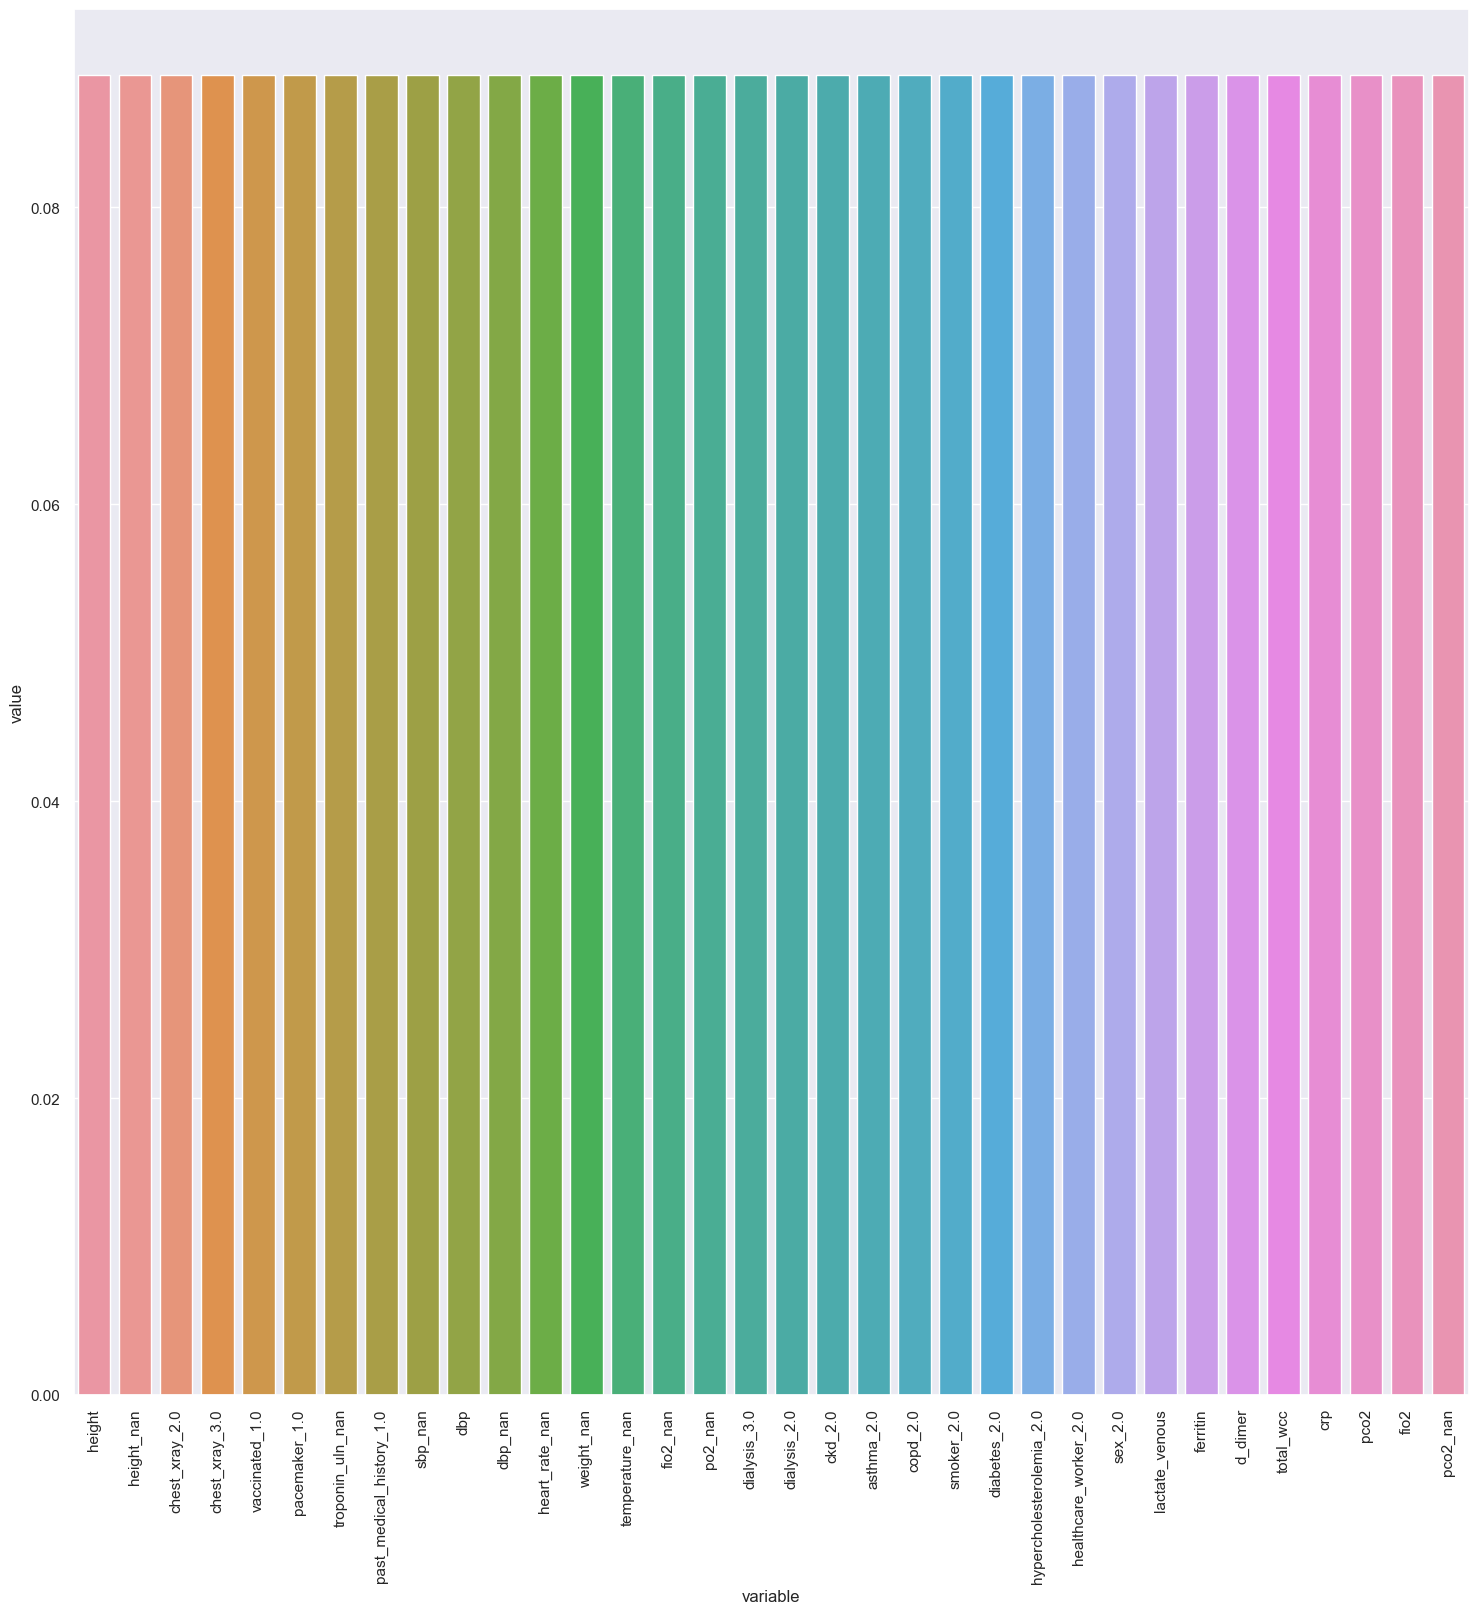

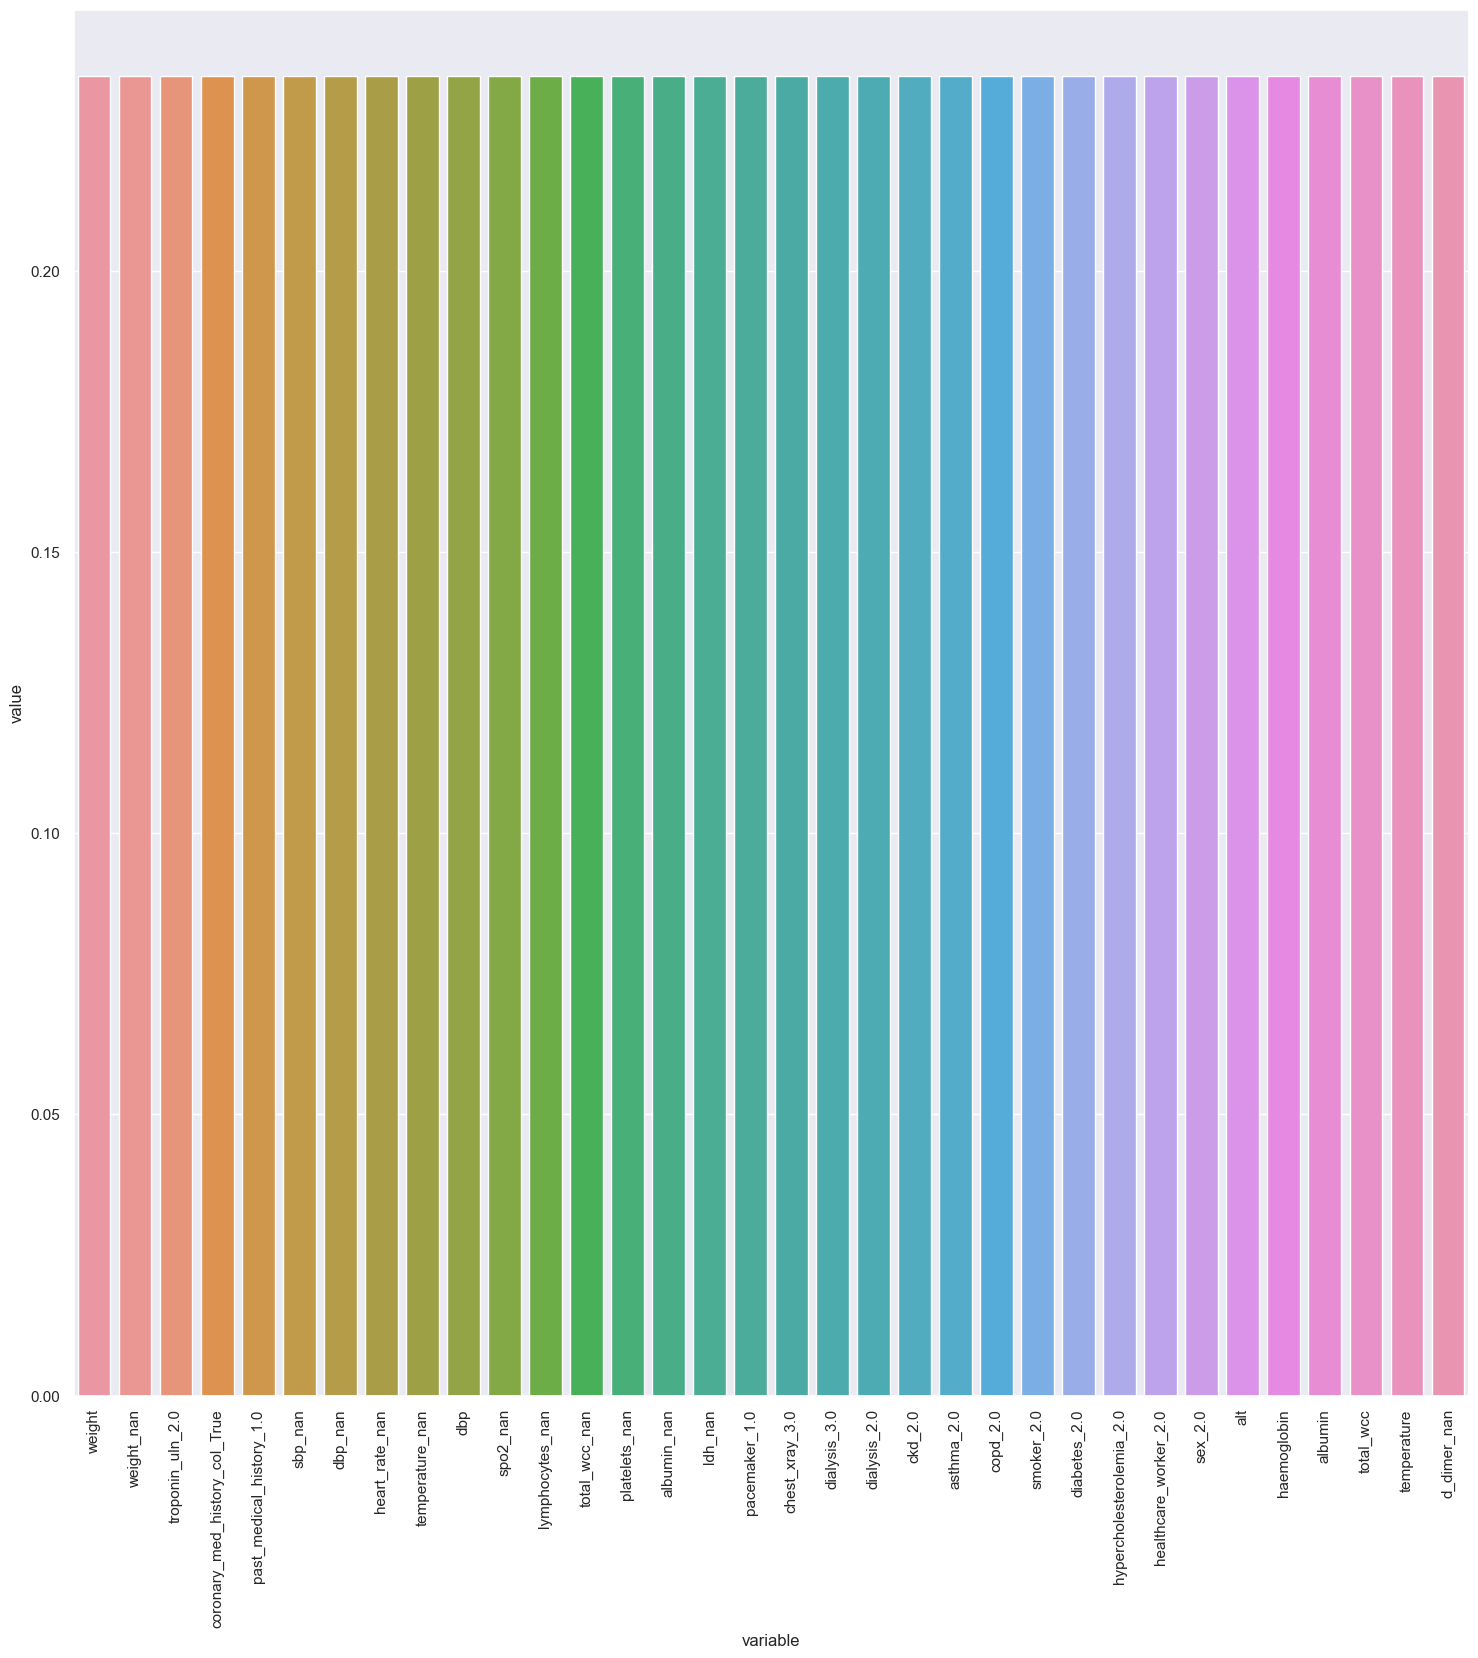

In [44]:
for p in predictor:
    test = joblib.load("model/decision_tree_full_feature_selection_"+p+".pickle")
    feature_select = test.steps[1][1].support_
    coefs = test.steps[2][1].feature_importances_
    
    coef_df = pd.DataFrame(data = {'variable' : X.columns[feature_select],
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('value', ascending=False)
    plt.figure(figsize=(18, 18))
    sns.barplot(
        data=coef_df, x="variable", y="value")
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=90)

In [45]:
for p in predictor:
    test = joblib.load("model/decision_tree_full_feature_selection_"+p+".pickle")
    test_pipe = make_pipeline(
        StandardScaler(), 
        DecisionTreeClassifier(**test.steps[2][1].get_params()))
    feature_select = test.steps[1][1].support_
    tmp_df = pd.DataFrame.from_dict({'model': ['decision_tree_full'],
               'outcome': [p],
               'accuracy': [np.mean(cross_val_score(test_pipe, X_train.loc[:,feature_select], y_train, cv=5))]})
    score_df = pd.concat([score_df,tmp_df],ignore_index=True)

In [47]:
score_df.to_csv("result/outcome.csv")

## Random forest

In [55]:
score_df = pd.read_csv("result/outcome.csv",index_col=0)

In [56]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()), 
    ("tree", RandomForestClassifier(random_state=random_seed,max_features = 'sqrt',n_estimators=100))])

param_grid = {
    "tree__criterion": ['gini', 'entropy'],
    'tree__min_samples_split':np.linspace(0.02,0.3,num=10) 
}

grid = GridSearchCV(pipeline,
                    param_grid = param_grid,cv=5)

In [57]:
for p in predictor:
    y = df_dummy[p]
    X = df_dummy.drop(predictor, axis=1)
    X_train= X.iloc[train,:]
    y_train = y.iloc[train]
    grid.fit(X_train, y_train)
    
    pipe = Pipeline(steps=[
         ("scaler", StandardScaler()), 
        ("feature_select",
         SequentialFeatureSelector(
             RandomForestClassifier(
                 criterion = grid.best_params_["tree__criterion"],
                 min_samples_split = grid.best_params_["tree__min_samples_split"])
            ,n_features_to_select=15)),
        ("rf",
         RandomForestClassifier(
                 criterion = grid.best_params_["tree__criterion"],
                 min_samples_split = grid.best_params_["tree__min_samples_split"]))])
    
    pipe.fit(X_train, y_train)
    joblib.dump(pipe,"model/rf_feature_selection_"+p+".pickle")

In [58]:
for p in predictor:
    test = joblib.load("model/rf_feature_selection_"+p+".pickle")
    test_pipe = make_pipeline(
        StandardScaler(), 
        RandomForestClassifier(**test.steps[2][1].get_params()))
    feature_select = test.steps[1][1].support_
    tmp_df = pd.DataFrame.from_dict({'model': ['rf'],
               'outcome': [p],
               'accuracy': [np.mean(cross_val_score(test_pipe, X_train.loc[:,feature_select], y_train, cv=5))]})
    score_df = pd.concat([score_df,tmp_df],ignore_index=True)

In [59]:
score_df

,model,accuracy,outcome
0,logistic,0.905184,death
1,logistic,0.936539,intubation
2,logistic,0.947482,complication
3,logistic+l2,0.942378,intubation_dummy
4,logistic+l2,0.945295,death
5,logistic+l2,0.948215,cardio_complication
6,baseline,0.918291,intubation_dummy
7,baseline,0.889855,death
8,baseline,0.934349,cardio_complication
9,decision_tree,0.937277,intubation_dummy


In [60]:
for p in predictor:
    test = joblib.load("model/rf_feature_selection_"+p+".pickle")
    feature_select = test.steps[1][1].support_
    coefs = test.steps[2][1].feature_importances_

    importances = test.steps[2][1].feature_importances_
    std = np.std([tree.feature_importances_ for tree in test.steps[2][1].estimators_], axis=0)


    forest_importances = pd.Series(importances, index= X.columns)
    forest_importances = forest_importances.sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(18, 18))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

ValueError: Length of values (15) does not match length of index (69)